In [2]:
# Basic data manipulations
import pandas as pd
import numpy as np

# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder


# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
import seaborn as sns


import albumentations as A
from albumentations.pytorch import ToTensorV2
! pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 4.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=1ae7aad325cac1568558bfcb5c795b21efe6d381edc615dfb2d3577c0dc7dc3e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=57ace6b600d18d90201bd45cd63238229e8bbe56a7b6df6d7605e8ff4aa0d283
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
# read img and mask
train_img_paths = sorted(glob('/Users/tanmoyroy/Desktop/paper/cpm17/train/images/*.png'))
train_mask_paths = sorted(glob('/Users/tanmoyroy/Desktop/paper/cpm17/train/masks/*.png'))
train_df = pd.DataFrame({"images":train_img_paths,"masks":train_mask_paths})
train_df.head()

,images,masks
0,/kaggle/input/tnbc-dataset1/TNBC/train/images/...,/kaggle/input/tnbc-dataset1/TNBC/train/masks/m...
1,/kaggle/input/tnbc-dataset1/TNBC/train/images/...,/kaggle/input/tnbc-dataset1/TNBC/train/masks/m...
2,/kaggle/input/tnbc-dataset1/TNBC/train/images/...,/kaggle/input/tnbc-dataset1/TNBC/train/masks/m...
3,/kaggle/input/tnbc-dataset1/TNBC/train/images/...,/kaggle/input/tnbc-dataset1/TNBC/train/masks/m...
4,/kaggle/input/tnbc-dataset1/TNBC/train/images/...,/kaggle/input/tnbc-dataset1/TNBC/train/masks/m...


In [4]:
# read img and mask
val_img_paths = sorted(glob('/Users/tanmoyroy/Desktop/paper/cpm17/validation/images/*.png'))
val_mask_paths = sorted(glob('/Users/tanmoyroy/Desktop/paper/cpm17/validation/masks/*.png'))
val_df = pd.DataFrame({"images":val_img_paths,"masks":val_mask_paths})
val_df.head()

,images,masks
0,/kaggle/input/tnbc-dataset1/TNBC/val/images/im...,/kaggle/input/tnbc-dataset1/TNBC/val/masks/mas...
1,/kaggle/input/tnbc-dataset1/TNBC/val/images/im...,/kaggle/input/tnbc-dataset1/TNBC/val/masks/mas...
2,/kaggle/input/tnbc-dataset1/TNBC/val/images/im...,/kaggle/input/tnbc-dataset1/TNBC/val/masks/mas...


In [5]:
# read img and mask
test_img_paths = sorted(glob('/Users/tanmoyroy/Desktop/paper/cpm17/test/images/*.png'))
test_mask_paths = sorted(glob('/Users/tanmoyroy/Desktop/paper/cpm17/test/masks/*.png'))
test_df = pd.DataFrame({"images":test_img_paths,"masks":test_mask_paths})
test_df.head()

,images,masks
0,/kaggle/input/tnbc-dataset1/TNBC/test/images/i...,/kaggle/input/tnbc-dataset1/TNBC/test/masks/ma...
1,/kaggle/input/tnbc-dataset1/TNBC/test/images/i...,/kaggle/input/tnbc-dataset1/TNBC/test/masks/ma...


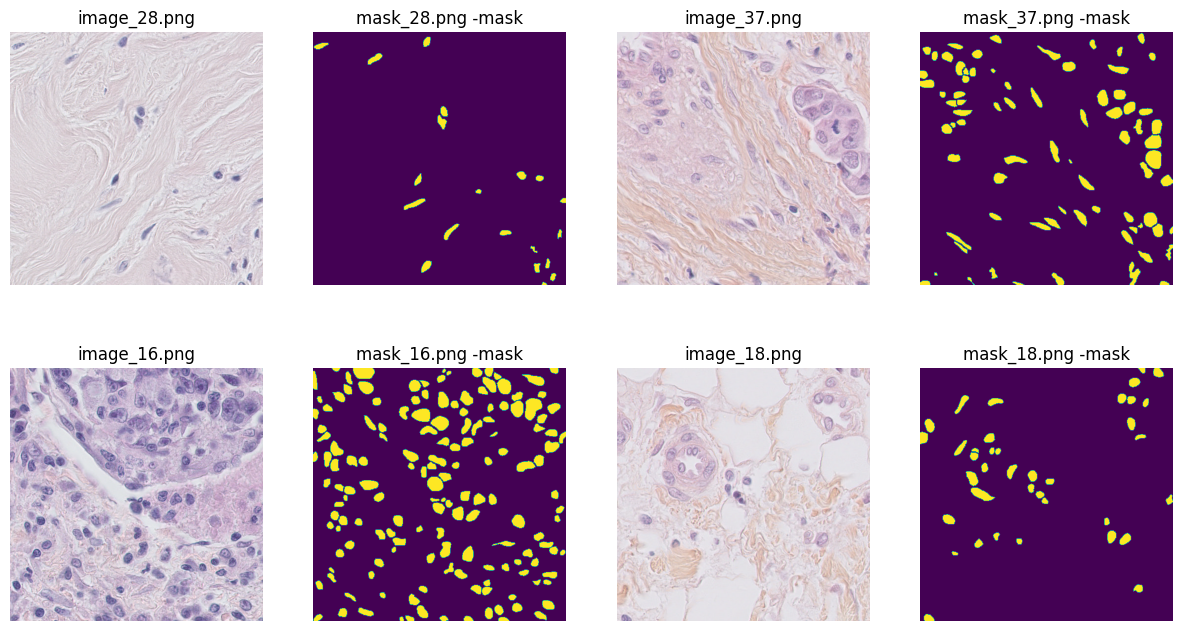

In [6]:
show_imgs = 4
idx = np.random.choice(len(train_df), show_imgs, replace=False)
fig, axes = plt.subplots(show_imgs*2//4, 4, figsize=(15, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    new_i = i//2
    if i % 2 ==0 :
        full_path = train_df.loc[idx[new_i]]['images']
        basename = os.path.basename(full_path)
    else:
        full_path = train_df.loc[idx[new_i]]['masks']
        basename = os.path.basename(full_path) + ' -mask'
    ax.imshow(plt.imread(full_path))
    ax.set_title(basename)
    ax.set_axis_off()

In [7]:
train_transforms = A.Compose([
    A.Resize(512, 512),
    A.RandomCrop(height=512, width=512, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04,0.04), rotate_limit=(-15,15), p=0.5),
    # A.Normalize(p=1.0),
    # ToTensorV2(),
])

val_transforms = A.Compose([
    A.Resize(512, 512),
    # ToTensorV2(),
])

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_=None):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 2

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['images']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['masks'],cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        aug = self.transforms_(image=img, mask=mask)
        img, mask = aug['image'], aug['mask']
        img = img/255
        # img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        #target = torch.tensor(mask, dtype=torch.long)
        # Convert target (mask) to tensor and resize it first
        target = torch.tensor(mask, dtype=torch.float)  # Convert to tensor, shape: [1, 512, 512]

        # Resize the target tensor before creating the sample dictionary
        #target_resized = target.view(3, self.resize[0], self.resize[1])

        # Now create the sample dictionary with the resized target
        sample = {'x': img, 'y': target}

        #sample = {'x': img, 'y': target}
        return sample


In [8]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, val_transforms)

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
print(f'len train: {len(train_df)}')
print(f'len val: {len(val_df)}')

len train: 45
len val: 3


In [9]:

import torch
import torch.nn as nn

try:
    from inplace_abn import InPlaceABN
except ImportError:
    InPlaceABN = None


class Conv2dReLU(nn.Sequential):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding=0,
        stride=1,
        use_batchnorm=True,
    ):
        if use_batchnorm == "inplace" and InPlaceABN is None:
            raise RuntimeError(
                "In order to use `use_batchnorm='inplace'` inplace_abn package must be installed. "
                + "To install see: https://github.com/mapillary/inplace_abn"
            )

        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        if use_batchnorm == "inplace":
            bn = InPlaceABN(out_channels, activation="leaky_relu", activation_param=0.0)
            relu = nn.Identity()

        elif use_batchnorm and use_batchnorm != "inplace":
            bn = nn.BatchNorm2d(out_channels)

        else:
            bn = nn.Identity()

        super(Conv2dReLU, self).__init__(conv, bn, relu)

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)

    def forward(self, x):
        batch_size, channels, h, w = x.size()

        # Compute average and max across the spatial dimensions separately
        avg_out = torch.mean(x, dim=[2, 3])
        max_out, _ = torch.max(torch.max(x, dim=2)[0], dim=2)  # First max over height, then over width

        # Apply the fully connected layers to the attention mechanism
        out = F.relu(self.fc1(avg_out) + self.fc1(max_out))
        out = torch.sigmoid(self.fc2(out)).view(batch_size, channels, 1, 1)
        return x * out

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = torch.sigmoid(self.conv1(x_cat))
        return x * out

class GatedAxialAttentionBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        groups=8
        kernel_size=7
        stride=1
        bias=True
        # Ensure that in_channels is divisible by groups
        if in_channels % groups != 0:
            raise ValueError(f"in_channels ({in_channels}) must be divisible by groups ({groups})")

        # Calculate out_channels for channel attention based on reduction
        reduced_channels = in_channels // reduction

        super().__init__()

        # Channel-wise attention (cSE)
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, reduced_channels, 1),  # reduce channels for channel attention
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, in_channels, 1),  # restore channels back to in_channels
            nn.Sigmoid(),
        )

        # Spatial-wise attention (sSE) with variable kernel size
        self.sSE = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=kernel_size, padding=kernel_size // 2),  # kernel_size is now adjustable
            nn.Sigmoid()
        )

        # Axial attention components with same input/output channels
        self.q_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, groups=groups)
        self.k_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, groups=groups)
        self.v_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, groups=groups)

        # Gating mechanism
        self.gate = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.size()

        # Channel-wise attention (cSE)
        channel_att = self.cSE(x)  # Shape: [B, C, 1, 1]
        x_c = x * channel_att  # Apply channel-wise attention

        # Spatial-wise attention (sSE)
        spatial_att = self.sSE(x)  # Shape: [B, 1, H, W]
        x_s = x * spatial_att  # Apply spatial-wise attention

        # Axial attention mechanism
        q = self.q_conv(x)  # Query [B, C, H, W]
        k = self.k_conv(x)  # Key [B, C, H, W]
        v = self.v_conv(x)  # Value [B, C, H, W]

        # Reshape and compute attention map
        q_flat = q.view(B, -1, H * W)  # Flatten spatial dimensions
        k_flat = k.view(B, -1, H * W)  # Flatten spatial dimensions
        v_flat = v.view(B, -1, H * W)  # Flatten spatial dimensions

        attn_map = torch.bmm(q_flat.transpose(1, 2), k_flat)  # Dot-product attention
        attn_map = torch.softmax(attn_map, dim=-1)  # Apply softmax

        out = torch.bmm(v_flat, attn_map.transpose(1, 2))  # Apply attention to value
        out = out.view(B, C, H, W)  # Reshape back to original dimensions

        # Gating mechanism
        gate = self.gate(x)  # Shape: [B, C, H, W]
        gated_out = out * gate  # Gated axial attention output

        # Combine both channel and spatial attention with gated axial attention output
        return x_c + x_s + gated_out

class LEQCA_Block(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(LEQCA_Block, self).__init__()
        self.in_channels = in_channels
        self.reduction = reduction

        # Global Average Pooling to get the channel-wise global feature
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # First fully connected layer for latent entropy approximation
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, bias=False)

        # Second fully connected layer to calculate the attention values
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, bias=False)

        # Sigmoid to get the attention values between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, num_channels, h, w = x.size()

        # Step 1: Global Average Pooling
        avg_out = self.global_pool(x)  # Shape: [batch_size, num_channels, 1, 1]

        # Step 2: First fully connected layer with latent entropy
        latent_entropy = F.relu(self.fc1(avg_out))  # Shape: [batch_size, num_channels // reduction, 1, 1]

        # Step 3: Second fully connected layer to get channel weights
        attention_weights = self.fc2(latent_entropy)  # Shape: [batch_size, num_channels, 1, 1]

        # Step 4: Apply sigmoid to the attention weights
        attention_weights = self.sigmoid(attention_weights)

        # Step 5: Multiply input features by attention weights (element-wise)
        out = x * attention_weights.expand_as(x)

        return out


class ComprehensiveAttention(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(ComprehensiveAttention, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class SCSEModule(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(nn.Conv2d(in_channels, 1, 1), nn.Sigmoid())

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)



class ArgMax(nn.Module):
    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.argmax(x, dim=self.dim)


class Clamp(nn.Module):
    def __init__(self, min=0, max=1):
        super().__init__()
        self.min, self.max = min, max

    def forward(self, x):
        return torch.clamp(x, self.min, self.max)


class Activation(nn.Module):
    def __init__(self, name, **params):
        super().__init__()

        if name is None or name == "identity":
            self.activation = nn.Identity(**params)
        elif name == "sigmoid":
            self.activation = nn.Sigmoid()
        elif name == "softmax2d":
            self.activation = nn.Softmax(dim=1, **params)
        elif name == "softmax":
            self.activation = nn.Softmax(**params)
        elif name == "logsoftmax":
            self.activation = nn.LogSoftmax(**params)
        elif name == "tanh":
            self.activation = nn.Tanh()
        elif name == "argmax":
            self.activation = ArgMax(**params)
        elif name == "argmax2d":
            self.activation = ArgMax(dim=1, **params)
        elif name == "clamp":
            self.activation = Clamp(**params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError(
                f"Activation should be callable/sigmoid/softmax/logsoftmax/tanh/"
                f"argmax/argmax2d/clamp/None; got {name}"
            )

    def forward(self, x):
        return self.activation(x)


class Attention(nn.Module):
    def __init__(self, name, in_channels=None, out_channels=None, **params):
        super().__init__()

        if name is None:
            self.attention = nn.Identity(**params)
        elif name == "scse":
            self.attention = SCSEModule(**params)
        elif name == "comattn":
            self.attention = ComprehensiveAttention(**params)
        elif name == "sa":
            self.attention = SpatialAttention(**params)
        elif name == "ca":
            self.attention = ChannelAttention(**params)
        elif name == "leqca":
            self.attention = LEQCA_Block(**params)
        elif name == "gaa":
            # Explicitly pass in_channels and out_channels
            if in_channels is None or out_channels is None:
                raise ValueError("in_channels and out_channels must be specified for axial attention")
            # Assuming in_channels = 160
            # Change reduction to 10 or change groups to a compatible value
            # Assuming in_channels = 100
            self.attention = GatedAxialAttentionBlock(**params)

        else:
            raise ValueError("Attention {} is not implemented".format(name))

    def forward(self, x):
        return self.attention(x)


In [10]:
import torch.nn as nn
#####from .modules import Activation


class SegmentationHead(nn.Sequential):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, activation=None, upsampling=1
    ):
        conv2d = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2
        )
        upsampling = (
            nn.UpsamplingBilinear2d(scale_factor=upsampling)
            if upsampling > 1
            else nn.Identity()
        )
        activation = Activation(activation)
        super().__init__(conv2d, upsampling, activation)


class ClassificationHead(nn.Sequential):
    def __init__(
        self, in_channels, classes, pooling="avg", dropout=0.2, activation=None
    ):
        if pooling not in ("max", "avg"):
            raise ValueError(
                "Pooling should be one of ('max', 'avg'), got {}.".format(pooling)
            )
        pool = nn.AdaptiveAvgPool2d(1) if pooling == "avg" else nn.AdaptiveMaxPool2d(1)
        flatten = nn.Flatten()
        dropout = nn.Dropout(p=dropout, inplace=True) if dropout else nn.Identity()
        linear = nn.Linear(in_channels, classes, bias=True)
        activation = Activation(activation)
        super().__init__(pool, flatten, dropout, linear, activation)

In [11]:
import torch
from segmentation_models_pytorch.base import initialization as init
#####from . import initialization as init
#####from .hub_mixin import SMPHubMixin
from segmentation_models_pytorch.base.hub_mixin import SMPHubMixin

class SegmentationModel(torch.nn.Module, SMPHubMixin):
    def initialize(self):
        init.initialize_decoder(self.decoder)
        init.initialize_head(self.segmentation_head)
        if self.classification_head is not None:
            init.initialize_head(self.classification_head)

    def check_input_shape(self, x):
        h, w = x.shape[-2:]
        output_stride = self.encoder.output_stride
        if h % output_stride != 0 or w % output_stride != 0:
            new_h = (
                (h // output_stride + 1) * output_stride
                if h % output_stride != 0
                else h
            )
            new_w = (
                (w // output_stride + 1) * output_stride
                if w % output_stride != 0
                else w
            )
            raise RuntimeError(
                f"Wrong input shape height={h}, width={w}. Expected image height and width "
                f"divisible by {output_stride}. Consider pad your images to shape ({new_h}, {new_w})."
            )

    def forward(self, x):
        """Sequentially pass `x` trough model`s encoder, decoder and heads"""

        self.check_input_shape(x)

        features = self.encoder(x)
        decoder_output = self.decoder(*features)

        masks = self.segmentation_head(decoder_output)

        if self.classification_head is not None:
            labels = self.classification_head(features[-1])
            return masks, labels

        return masks

    @torch.no_grad()
    def predict(self, x):
        """Inference method. Switch model to `eval` mode, call `.forward(x)` with `torch.no_grad()`

        Args:
            x: 4D torch tensor with shape (batch_size, channels, height, width)

        Return:
            prediction: 4D torch tensor with shape (batch_size, classes, height, width)

        """
        if self.training:
            self.eval()

        x = self.forward(x)

        return x

In [12]:

import torch
import torch.nn as nn
import torch.nn.functional as F

#####from segmentation_models_pytorch.base import modules as md

class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        use_batchnorm=True,
        attention_type=None,
    ):
        super().__init__()
        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = Attention(
            attention_type, in_channels=in_channels + skip_channels
        )
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class CenterBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        conv1 = Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        super().__init__(conv1, conv2)


class UnetDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels,
        n_blocks=5,
        use_batchnorm=True,
        attention_type=None,
        center=False,
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[1:]
        # reverse channels to start from head of encoder
        encoder_channels = encoder_channels[::-1]

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        if center:
            self.center = CenterBlock(
                head_channels, head_channels, use_batchnorm=use_batchnorm
            )
        else:
            self.center = nn.Identity()

        # combine decoder keyword arguments
        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch, **kwargs)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):
        features = features[1:]  # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]

        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        return x

In [13]:
!pip install pytorch-wavelets
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 1.7 MB/s eta 0:00:00


In [14]:
import torch
import torch.nn.functional as F
from pytorch_wavelets import DTCWTForward, DTCWTInverse

def Wavelet_Transform(image):
    # Ensure image and wavelet transform are on the same device
    device = image.device
    
    # Initialize DTCWT forward transform
    xfm = DTCWTForward(J=1, mode='symmetric').to(device)
    
    # Perform DTCWT decomposition
    Yl, Yh = xfm(image)
    
    # Upsample Yl to match the input shape
    Yl_upsampled = F.interpolate(Yl, size=(image.shape[2], image.shape[3]), mode='bilinear', align_corners=False)
    
    return Yl_upsampled

In [15]:
import torch
import torch.nn as nn
import numpy as np
import functools
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from pretrainedmodels.models.inceptionv4 import InceptionV4, pretrained_settings


class SAA_Block(nn.Module):
    """Selective Attention Aggregation Block."""
    def __init__(self, in_channels, reduction=16):
        super(SAA_Block, self).__init__()
        self.in_channels = in_channels
        self.reduction = reduction

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        pooled = self.global_pool(x)
        attention = self.fc1(pooled)
        attention = F.relu(attention)
        attention = self.fc2(attention)
        attention = self.sigmoid(attention)
        return x * attention.expand_as(x)

class MAA_Block(nn.Module):
    """Memory Augmented Attention Block."""
    def __init__(self, in_channels, memory_slots=16, reduction=16):
        super(MAA_Block, self).__init__()
        self.in_channels = in_channels
        self.memory_slots = memory_slots
        self.reduction = reduction

        self.memory = nn.Parameter(torch.randn(memory_slots, in_channels))
        self.query = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, bias=False)
        self.key = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.value = nn.Linear(in_channels, in_channels, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        x_flat = x.view(batch_size, channels, -1)

        query = self.query(x).view(batch_size, channels // self.reduction, -1)
        key = self.key(self.memory).permute(1, 0).unsqueeze(0).expand(batch_size, -1, -1)
        value = self.value(self.memory).unsqueeze(0).expand(batch_size, -1, -1)

        attention_weights = torch.bmm(query.permute(0, 2, 1), key)
        attention_weights = self.softmax(attention_weights)

        attention_output = torch.bmm(attention_weights, value)
        attention_output = attention_output.permute(0, 2, 1).view(batch_size, channels, height, width)
        return attention_output + x



# Combined Ensemble Attention Block (MAA+SAA)
class EnsembleAttention(nn.Module):
    def __init__(self, in_channels):
        super(EnsembleAttention, self).__init__()
        self.saa_block = SAA_Block(in_channels)
        self.maa_block = MAA_Block(in_channels)

    def forward(self, x):
        saa_out = self.saa_block(x)
        maa_out = self.maa_block(x)
        ensemble_out = (saa_out + maa_out) / 2  # Averaging outputs
        return ensemble_out



# Encoder Mixin
class EncoderMixin:
    _output_stride = 32

    @property
    def out_channels(self):
        return self._out_channels[:self._depth + 1]

    @property
    def output_stride(self):
        return min(self._output_stride, 2 ** self._depth)

    def set_in_channels(self, in_channels, pretrained=True):
        if in_channels == 3:
            return
        self._in_channels = in_channels
        if self._out_channels[0] == 3:
            self._out_channels = tuple([in_channels] + list(self._out_channels)[1:])
        patch_first_conv(self, new_in_channels=in_channels, pretrained=pretrained)

    def make_dilated(self, output_stride):
        if output_stride == 16:
            stage_list, dilation_list = [5], [2]
        elif output_stride == 8:
            stage_list, dilation_list = [4, 5], [2, 4]
        else:
            raise ValueError("Output stride must be 16 or 8.")
        self._output_stride = output_stride
        stages = self.get_stages()
        for stage_idx, dilation_rate in zip(stage_list, dilation_list):
            replace_strides_with_dilation(stages[stage_idx], dilation_rate)


# InceptionV4 Encoder with MSCA + LEQCA Ensemble Attention
class InceptionV4Encoder(InceptionV4, EncoderMixin):
    def __init__(self, stage_idxs, out_channels, depth=5, **kwargs):
        super().__init__(**kwargs)
        self._stage_idxs = stage_idxs
        self._out_channels = out_channels
        self._depth = depth
        self._in_channels = 3
        self.attention_blocks = nn.ModuleList(
            [EnsembleAttention(out_channels[i]) for i in range(1, depth + 1)]
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d) and m.kernel_size == (3, 3):
                m.padding = (1, 1)
            if isinstance(m, nn.MaxPool2d):
                m.padding = (1, 1)
        del self.last_linear

    def get_stages(self):
        """Defines the stages based on the stage indexes provided."""
        return [
            nn.Identity(),  # First stage is a placeholder (no processing)
            self.features[:self._stage_idxs[0]],  # First block of layers
            self.features[self._stage_idxs[0]:self._stage_idxs[1]],  # Second block of layers
            self.features[self._stage_idxs[1]:self._stage_idxs[2]],  # Third block of layers
            self.features[self._stage_idxs[2]:self._stage_idxs[3]],  # Fourth block of layers
            self.features[self._stage_idxs[3]:],  # Fifth block of layers
        ]

    def forward(self, x):
        features = []
        for i in range(self._depth + 1):
            x = self.get_stages()[i](x)
            if i > 0:
                x = self.attention_blocks[i - 1](x)  # Apply ensemble attention (MSCA + LEQCA)
            
            # Apply wavelet transform to the feature map
            x_wavelet = Wavelet_Transform(x)  # Ensure Wavelet_Transform is defined properly
            features.append(x_wavelet)  # Append the wavelet-transformed feature
        return features


    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop("last_linear.bias", None)
        state_dict.pop("last_linear.weight", None)
        super().load_state_dict(state_dict, **kwargs)


# Utility Functions
def patch_first_conv(model, new_in_channels, default_in_channels=3, pretrained=True):
    for module in model.modules():
        if isinstance(module, nn.Conv2d) and module.in_channels == default_in_channels:
            break
    weight = module.weight.detach()
    module.in_channels = new_in_channels
    if not pretrained:
        module.weight = nn.parameter.Parameter(
            torch.Tensor(module.out_channels, new_in_channels // module.groups, *module.kernel_size))
        module.reset_parameters()
    elif new_in_channels == 1:
        module.weight = nn.parameter.Parameter(weight.sum(1, keepdim=True))
    else:
        new_weight = torch.Tensor(module.out_channels, new_in_channels // module.groups, *module.kernel_size)
        for i in range(new_in_channels):
            new_weight[:, i] = weight[:, i % default_in_channels]
        new_weight *= (default_in_channels / new_in_channels)
        module.weight = nn.parameter.Parameter(new_weight)


def replace_strides_with_dilation(module, dilation_rate):
    for mod in module.modules():
        if isinstance(mod, nn.Conv2d):
            mod.stride = (1, 1)
            mod.dilation = (dilation_rate, dilation_rate)
            kh, kw = mod.kernel_size
            mod.padding = ((kh // 2) * dilation_rate, (kw // 2) * dilation_rate)
            if hasattr(mod, "static_padding"):
                mod.static_padding = nn.Identity()


# Preprocessing Functions
def preprocess_input(x, mean=None, std=None, input_space="RGB", input_range=None, **kwargs):
    if input_space == "BGR":
        x = x[..., ::-1].copy()
    if input_range is not None and x.max() > 1 and input_range[1] == 1:
        x = x / 255.0
    if mean is not None:
        x -= np.array(mean)
    if std is not None:
        x /= np.array(std)
    return x


# Encoder Retrieval Functions
inceptionv4_encoders = {
    "inceptionv4": {
        "encoder": InceptionV4Encoder,
        "pretrained_settings": pretrained_settings["inceptionv4"],
        "params": {
            "stage_idxs": (3, 5, 9, 15),
            "out_channels": (3, 64, 192, 384, 1024, 1536),
            "num_classes": 1001,
        },
    }
}


def get_encoder(name, in_channels=3, depth=5, weights=None, output_stride=32, **kwargs):
    if name not in inceptionv4_encoders:
        raise KeyError(f"Unsupported encoder `{name}`, supported: {list(inceptionv4_encoders.keys())}")

    Encoder = inceptionv4_encoders[name]["encoder"]
    params = inceptionv4_encoders[name]["params"]
    params.update(depth=depth)
    encoder = Encoder(**params)

    if weights:
        settings = inceptionv4_encoders[name]["pretrained_settings"][weights]
        pretrained_dict = model_zoo.load_url(settings["url"])
        model_dict = encoder.state_dict()

        # Filter out attention block weights, which are not present in pre-trained weights
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and "attention_blocks" not in k}
        model_dict.update(pretrained_dict)

        encoder.load_state_dict(model_dict)

    encoder.set_in_channels(in_channels, pretrained=weights is not None)
    if output_stride != 32:
        encoder.make_dilated(output_stride=output_stride)

    return encoder


# Preprocessing functions
def get_preprocessing_params(encoder_name, pretrained="imagenet"):
    settings = inceptionv4_encoders[encoder_name]["pretrained_settings"].get(pretrained)
    return {
        "input_space": settings.get("input_space", "RGB"),
        "input_range": list(settings.get("input_range", [0, 1])),
        "mean": list(settings["mean"]),
        "std": list(settings["std"]),
    }


def get_preprocessing_fn(encoder_name, pretrained="imagenet"):
    params = get_preprocessing_params(encoder_name, pretrained)
    return functools.partial(preprocess_input, **params)


In [16]:
from typing import Optional, Union, List
"""
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import (
    SegmentationModel,
    SegmentationHead,
    ClassificationHead,
)
"""
#####from .decoder import UnetDecoder

class Unet(SegmentationModel):
    """Unet_ is a fully convolution neural network for image semantic segmentation. Consist of *encoder*
    and *decoder* parts connected with *skip connections*. Encoder extract features of different spatial
    resolution (skip connections) which are used by decoder to define accurate segmentation mask. Use *concatenation*
    for fusing decoder blocks with skip connections.

    Args:
        encoder_name: Name of the classification model that will be used as an encoder (a.k.a backbone)
            to extract features of different spatial resolution
        encoder_depth: A number of stages used in encoder in range [3, 5]. Each stage generate features
            two times smaller in spatial dimensions than previous one (e.g. for depth 0 we will have features
            with shapes [(N, C, H, W),], for depth 1 - [(N, C, H, W), (N, C, H // 2, W // 2)] and so on).
            Default is 5
        encoder_weights: One of **None** (random initialization), **"imagenet"** (pre-training on ImageNet) and
            other pretrained weights (see table with available weights for each encoder_name)
        decoder_channels: List of integers which specify **in_channels** parameter for convolutions used in decoder.
            Length of the list should be the same as **encoder_depth**
        decoder_use_batchnorm: If **True**, BatchNorm2d layer between Conv2D and Activation layers
            is used. If **"inplace"** InplaceABN will be used, allows to decrease memory consumption.
            Available options are **True, False, "inplace"**
        decoder_attention_type: Attention module used in decoder of the model. Available options are
            **None** and **scse** (https://arxiv.org/abs/1808.08127).
        in_channels: A number of input channels for the model, default is 3 (RGB images)
        classes: A number of classes for output mask (or you can think as a number of channels of output mask)
        activation: An activation function to apply after the final convolution layer.
            Available options are **"sigmoid"**, **"softmax"**, **"logsoftmax"**, **"tanh"**, **"identity"**,
                **callable** and **None**.
            Default is **None**
        aux_params: Dictionary with parameters of the auxiliary output (classification head). Auxiliary output is build
            on top of encoder if **aux_params** is not **None** (default). Supported params:
                - classes (int): A number of classes
                - pooling (str): One of "max", "avg". Default is "avg"
                - dropout (float): Dropout factor in [0, 1)
                - activation (str): An activation function to apply "sigmoid"/"softmax"
                    (could be **None** to return logits)

    Returns:
        ``torch.nn.Module``: Unet

    .. _Unet:
        https://arxiv.org/abs/1505.04597

    """

    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
    ):
        super().__init__()

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        self.decoder = UnetDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )

        if aux_params is not None:
            self.classification_head = ClassificationHead(
                in_channels=self.encoder.out_channels[-1], **aux_params
            )
        else:
            self.classification_head = None

        self.name = "u-{}".format(encoder_name)
        self.initialize()


In [17]:
!pip install torchinfo

In [18]:
!pip install torchsummary

In [19]:

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
"""
import segmentation_models_pytorch as smp
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
"""

"\nimport segmentation_models_pytorch as smp\nimport torch\ndevice = 'cuda' if torch.cuda.is_available() else 'cpu'\n"

In [20]:
import torch
from torchinfo import summary
#from model import Unet  # Assuming your model is saved in model.py

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class_size = 1
model = Unet(
    encoder_name="inceptionv4",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",
    #decoder_attention_type="leqca",             # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=class_size                      # model output channels (number of classes in your dataset)
).to(device)

# Get the summary
input_size = (1, 3, 512, 512)  # Batch size of 1, 3 channels, 512x512 image
summary(model, input_size=input_size, device=device)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth" to /root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth
100%|██████████| 163M/163M [08:00<00:00, 356kB/s] 


Layer (type:depth-idx)                             Output Shape              Param #
Unet                                               [1, 1, 512, 512]          --
├─InceptionV4Encoder: 1-1                          [1, 3, 512, 512]          --
│    └─Sequential: 2-9                             --                        (recursive)
│    │    └─BasicConv2d: 3-1                       [1, 32, 256, 256]         928
│    │    └─BasicConv2d: 3-2                       [1, 32, 256, 256]         9,280
│    │    └─BasicConv2d: 3-3                       [1, 64, 256, 256]         18,560
│    └─ModuleList: 2-10                            --                        (recursive)
│    │    └─EnsembleAttention: 3-4                 [1, 64, 256, 256]         6,144
│    └─Sequential: 2-9                             --                        (recursive)
│    │    └─Mixed_3a: 3-5                          [1, 160, 128, 128]        55,488
│    │    └─Mixed_4a: 3-6                          [1, 192, 128, 128]    

In [21]:
# Dice score implementation
def dice_score(pred, target, smooth=1e-6):
    pred = pred > 0.5  # Threshold predictions
    target = target > 0.5
    intersection = (pred * target).sum().float()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return dice

def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    epoch_loss = 0
    epoch_iou_score = 0
    epoch_dice_score = 0

    for batch_i, batch in enumerate(dataloader):
        x, y = batch['x'].to(device), batch['y'].to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        pred = torch.sigmoid(pred)
        pred = pred.squeeze(dim=1)
        y = y.round().long()

        # Calculate Dice score
        dice = dice_score(pred, y)
        epoch_dice_score += dice.item()

        # Calculate IoU score
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        epoch_iou_score += iou

        lr_scheduler.step()

    return epoch_loss / num_batches, epoch_dice_score / num_batches, epoch_iou_score / num_batches

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    epoch_loss = 0
    epoch_iou_score = 0
    epoch_dice_score = 0

    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch['x'].to(device), batch['y'].to(device)

            pred = model(x)
            loss = loss_fn(pred, y)

            epoch_loss += loss.item()

            pred = torch.sigmoid(pred)
            pred = pred.squeeze(dim=1)
            y = y.round().long()

            # Calculate Dice score
            dice = dice_score(pred, y)
            epoch_dice_score += dice.item()

            # Calculate IoU score
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
            iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            epoch_iou_score += iou

    return epoch_loss / num_batches, epoch_dice_score / num_batches, epoch_iou_score / num_batches


In [22]:
EPOCHS = 500
logs = {
    'train_loss': [], 'val_loss': [],
    'train_iou_score': [], 'val_iou_score': [],
    'train_dice_score': [], 'val_dice_score': []
}


if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")

loss_fn = smp.losses.DiceLoss(mode="binary")
#loss_fn = smp.losses.FocalLoss(mode="binary")

#loss_fn = DiceLoss(mode="binary")
#loss_fn = FocalLoss(mode="binary")

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 100, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

model.to(device)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_dice_score, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_dice_score, val_iou_score = test(val_loader, model, loss_fn)

    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_dice_score'].append(train_dice_score)
    logs['val_dice_score'].append(val_dice_score)
    logs['train_iou_score'].append(train_iou_score)
    logs['val_iou_score'].append(val_iou_score)

    print(f'EPOCH: {str(epoch+1).zfill(3)} | '
          f'train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} | '
          f'train_dice_score: {train_dice_score:.3f}, val_dice_score: {val_dice_score:.3f} | '
          f'train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} | '
          f'lr: {optimizer.param_groups[0]["lr"]}')

    # Save model
    torch.save(model.state_dict(), "checkpoints/last1.pth")
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best1.pth")
    else:
        counter += 1

    # Early stopping
    #if counter >= patience:
     #   print("Early stopping!")
     #   break


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH: 001 | train_loss: 0.6670, val_loss: 0.7046 | train_dice_score: 0.451, val_dice_score: 0.295 | train_iou_score: 0.310, val_iou_score: 0.173 | lr: 0.001


  0%|          | 1/500 [00:11<1:34:31, 11.37s/it]

EPOCH: 002 | train_loss: 0.5783, val_loss: 0.9521 | train_dice_score: 0.596, val_dice_score: 0.040 | train_iou_score: 0.448, val_iou_score: 0.020 | lr: 0.001


  0%|          | 2/500 [00:20<1:24:29, 10.18s/it]

EPOCH: 003 | train_loss: 0.4346, val_loss: 0.3121 | train_dice_score: 0.734, val_dice_score: 0.812 | train_iou_score: 0.586, val_iou_score: 0.683 | lr: 0.001


  1%|          | 3/500 [00:30<1:23:27, 10.07s/it]

EPOCH: 004 | train_loss: 0.3854, val_loss: 0.2355 | train_dice_score: 0.742, val_dice_score: 0.852 | train_iou_score: 0.601, val_iou_score: 0.742 | lr: 0.001


  1%|          | 4/500 [00:40<1:22:41, 10.00s/it]

EPOCH: 005 | train_loss: 0.3121, val_loss: 0.2196 | train_dice_score: 0.774, val_dice_score: 0.828 | train_iou_score: 0.633, val_iou_score: 0.706 | lr: 0.001


  1%|          | 5/500 [00:50<1:22:22,  9.99s/it]

EPOCH: 006 | train_loss: 0.3227, val_loss: 0.3343 | train_dice_score: 0.732, val_dice_score: 0.712 | train_iou_score: 0.596, val_iou_score: 0.553 | lr: 0.001


  1%|          | 6/500 [01:00<1:20:49,  9.82s/it]

EPOCH: 007 | train_loss: 0.2551, val_loss: 0.3079 | train_dice_score: 0.790, val_dice_score: 0.710 | train_iou_score: 0.655, val_iou_score: 0.551 | lr: 0.001


  1%|▏         | 7/500 [01:09<1:19:55,  9.73s/it]

EPOCH: 008 | train_loss: 0.2295, val_loss: 0.1958 | train_dice_score: 0.797, val_dice_score: 0.817 | train_iou_score: 0.663, val_iou_score: 0.691 | lr: 0.001


  2%|▏         | 8/500 [01:19<1:20:48,  9.86s/it]

EPOCH: 009 | train_loss: 0.2056, val_loss: 0.1697 | train_dice_score: 0.816, val_dice_score: 0.845 | train_iou_score: 0.690, val_iou_score: 0.732 | lr: 0.0001


  2%|▏         | 9/500 [01:29<1:21:26,  9.95s/it]

EPOCH: 010 | train_loss: 0.2164, val_loss: 0.1590 | train_dice_score: 0.806, val_dice_score: 0.856 | train_iou_score: 0.678, val_iou_score: 0.748 | lr: 0.0001


  2%|▏         | 10/500 [01:40<1:22:12, 10.07s/it]

EPOCH: 011 | train_loss: 0.1903, val_loss: 0.1658 | train_dice_score: 0.830, val_dice_score: 0.848 | train_iou_score: 0.710, val_iou_score: 0.736 | lr: 0.0001


  2%|▏         | 11/500 [01:49<1:21:22,  9.98s/it]

EPOCH: 012 | train_loss: 0.2024, val_loss: 0.1623 | train_dice_score: 0.820, val_dice_score: 0.851 | train_iou_score: 0.696, val_iou_score: 0.741 | lr: 0.0001


  2%|▏         | 12/500 [01:59<1:20:54,  9.95s/it]

EPOCH: 013 | train_loss: 0.1920, val_loss: 0.1703 | train_dice_score: 0.828, val_dice_score: 0.842 | train_iou_score: 0.707, val_iou_score: 0.727 | lr: 0.0001


  3%|▎         | 13/500 [02:09<1:20:48,  9.96s/it]

EPOCH: 014 | train_loss: 0.2156, val_loss: 0.1577 | train_dice_score: 0.807, val_dice_score: 0.855 | train_iou_score: 0.683, val_iou_score: 0.747 | lr: 0.0001


  3%|▎         | 14/500 [02:20<1:22:06, 10.14s/it]

EPOCH: 015 | train_loss: 0.2132, val_loss: 0.1639 | train_dice_score: 0.815, val_dice_score: 0.849 | train_iou_score: 0.691, val_iou_score: 0.737 | lr: 0.0001


  3%|▎         | 15/500 [02:30<1:22:37, 10.22s/it]

EPOCH: 016 | train_loss: 0.1961, val_loss: 0.1546 | train_dice_score: 0.823, val_dice_score: 0.858 | train_iou_score: 0.701, val_iou_score: 0.751 | lr: 0.0001


  3%|▎         | 16/500 [02:41<1:23:47, 10.39s/it]

EPOCH: 017 | train_loss: 0.1930, val_loss: 0.1524 | train_dice_score: 0.830, val_dice_score: 0.860 | train_iou_score: 0.710, val_iou_score: 0.755 | lr: 1e-05


  3%|▎         | 17/500 [02:52<1:24:26, 10.49s/it]

EPOCH: 018 | train_loss: 0.1931, val_loss: 0.1485 | train_dice_score: 0.832, val_dice_score: 0.864 | train_iou_score: 0.713, val_iou_score: 0.761 | lr: 1e-05


  4%|▎         | 18/500 [03:02<1:24:20, 10.50s/it]

EPOCH: 019 | train_loss: 0.2213, val_loss: 0.1523 | train_dice_score: 0.809, val_dice_score: 0.860 | train_iou_score: 0.681, val_iou_score: 0.755 | lr: 1e-05


  4%|▍         | 19/500 [03:12<1:23:01, 10.36s/it]

EPOCH: 020 | train_loss: 0.2159, val_loss: 0.1544 | train_dice_score: 0.817, val_dice_score: 0.858 | train_iou_score: 0.694, val_iou_score: 0.752 | lr: 1e-05


  4%|▍         | 20/500 [03:22<1:21:59, 10.25s/it]

EPOCH: 021 | train_loss: 0.1815, val_loss: 0.1550 | train_dice_score: 0.836, val_dice_score: 0.857 | train_iou_score: 0.719, val_iou_score: 0.750 | lr: 1e-05


  4%|▍         | 21/500 [03:32<1:21:01, 10.15s/it]

EPOCH: 022 | train_loss: 0.1814, val_loss: 0.1607 | train_dice_score: 0.836, val_dice_score: 0.851 | train_iou_score: 0.719, val_iou_score: 0.741 | lr: 1e-05


  4%|▍         | 22/500 [03:42<1:20:44, 10.13s/it]

EPOCH: 023 | train_loss: 0.2017, val_loss: 0.1575 | train_dice_score: 0.824, val_dice_score: 0.855 | train_iou_score: 0.703, val_iou_score: 0.746 | lr: 1e-05


  5%|▍         | 23/500 [03:52<1:20:30, 10.13s/it]

EPOCH: 024 | train_loss: 0.2160, val_loss: 0.1535 | train_dice_score: 0.814, val_dice_score: 0.859 | train_iou_score: 0.690, val_iou_score: 0.753 | lr: 1e-05


  5%|▍         | 24/500 [04:03<1:20:13, 10.11s/it]

EPOCH: 025 | train_loss: 0.2224, val_loss: 0.1491 | train_dice_score: 0.803, val_dice_score: 0.864 | train_iou_score: 0.682, val_iou_score: 0.760 | lr: 1.0000000000000002e-06


  5%|▌         | 25/500 [04:13<1:19:49, 10.08s/it]

EPOCH: 026 | train_loss: 0.1954, val_loss: 0.1512 | train_dice_score: 0.825, val_dice_score: 0.861 | train_iou_score: 0.704, val_iou_score: 0.756 | lr: 1.0000000000000002e-06


  5%|▌         | 26/500 [04:23<1:19:35, 10.07s/it]

EPOCH: 027 | train_loss: 0.1736, val_loss: 0.1539 | train_dice_score: 0.844, val_dice_score: 0.858 | train_iou_score: 0.730, val_iou_score: 0.751 | lr: 1.0000000000000002e-06


  5%|▌         | 27/500 [04:33<1:19:17, 10.06s/it]

EPOCH: 028 | train_loss: 0.1809, val_loss: 0.1548 | train_dice_score: 0.839, val_dice_score: 0.857 | train_iou_score: 0.723, val_iou_score: 0.750 | lr: 1.0000000000000002e-06


  6%|▌         | 28/500 [04:43<1:19:04, 10.05s/it]

EPOCH: 029 | train_loss: 0.1827, val_loss: 0.1536 | train_dice_score: 0.838, val_dice_score: 0.859 | train_iou_score: 0.722, val_iou_score: 0.752 | lr: 1.0000000000000002e-06


  6%|▌         | 29/500 [04:53<1:18:52, 10.05s/it]

EPOCH: 030 | train_loss: 0.1975, val_loss: 0.1520 | train_dice_score: 0.824, val_dice_score: 0.860 | train_iou_score: 0.701, val_iou_score: 0.754 | lr: 1.0000000000000002e-06


  6%|▌         | 30/500 [05:03<1:18:59, 10.08s/it]

EPOCH: 031 | train_loss: 0.2097, val_loss: 0.1496 | train_dice_score: 0.822, val_dice_score: 0.863 | train_iou_score: 0.700, val_iou_score: 0.759 | lr: 1.0000000000000002e-06


  6%|▌         | 31/500 [05:13<1:18:51, 10.09s/it]

EPOCH: 032 | train_loss: 0.1912, val_loss: 0.1509 | train_dice_score: 0.833, val_dice_score: 0.862 | train_iou_score: 0.714, val_iou_score: 0.757 | lr: 1.0000000000000002e-06


  6%|▋         | 32/500 [05:23<1:18:38, 10.08s/it]

EPOCH: 033 | train_loss: 0.1876, val_loss: 0.1519 | train_dice_score: 0.830, val_dice_score: 0.860 | train_iou_score: 0.710, val_iou_score: 0.755 | lr: 1.0000000000000002e-06


  7%|▋         | 33/500 [05:33<1:18:29, 10.08s/it]

EPOCH: 034 | train_loss: 0.1948, val_loss: 0.1523 | train_dice_score: 0.830, val_dice_score: 0.860 | train_iou_score: 0.712, val_iou_score: 0.755 | lr: 1.0000000000000002e-07


  7%|▋         | 34/500 [05:43<1:18:22, 10.09s/it]

EPOCH: 035 | train_loss: 0.1963, val_loss: 0.1539 | train_dice_score: 0.828, val_dice_score: 0.858 | train_iou_score: 0.708, val_iou_score: 0.752 | lr: 1.0000000000000002e-07


  7%|▋         | 35/500 [05:53<1:18:07, 10.08s/it]

EPOCH: 036 | train_loss: 0.1815, val_loss: 0.1502 | train_dice_score: 0.837, val_dice_score: 0.862 | train_iou_score: 0.720, val_iou_score: 0.757 | lr: 1.0000000000000002e-07


  7%|▋         | 36/500 [06:03<1:17:59, 10.08s/it]

EPOCH: 037 | train_loss: 0.1870, val_loss: 0.1531 | train_dice_score: 0.831, val_dice_score: 0.859 | train_iou_score: 0.712, val_iou_score: 0.752 | lr: 1.0000000000000002e-07


  7%|▋         | 37/500 [06:13<1:17:45, 10.08s/it]

EPOCH: 038 | train_loss: 0.1805, val_loss: 0.1532 | train_dice_score: 0.837, val_dice_score: 0.858 | train_iou_score: 0.720, val_iou_score: 0.752 | lr: 1.0000000000000002e-07


  8%|▊         | 38/500 [06:23<1:17:25, 10.06s/it]

EPOCH: 039 | train_loss: 0.1861, val_loss: 0.1496 | train_dice_score: 0.832, val_dice_score: 0.863 | train_iou_score: 0.714, val_iou_score: 0.759 | lr: 1.0000000000000002e-07


  8%|▊         | 39/500 [06:34<1:17:19, 10.06s/it]

EPOCH: 040 | train_loss: 0.1875, val_loss: 0.1533 | train_dice_score: 0.830, val_dice_score: 0.859 | train_iou_score: 0.711, val_iou_score: 0.752 | lr: 1.0000000000000002e-07


  8%|▊         | 40/500 [06:44<1:17:08, 10.06s/it]

EPOCH: 041 | train_loss: 0.2117, val_loss: 0.1525 | train_dice_score: 0.824, val_dice_score: 0.860 | train_iou_score: 0.702, val_iou_score: 0.755 | lr: 1.0000000000000002e-07


  8%|▊         | 41/500 [06:54<1:16:58, 10.06s/it]

EPOCH: 042 | train_loss: 0.1894, val_loss: 0.1606 | train_dice_score: 0.830, val_dice_score: 0.851 | train_iou_score: 0.710, val_iou_score: 0.740 | lr: 1.0000000000000004e-08


  8%|▊         | 42/500 [07:04<1:16:47, 10.06s/it]

EPOCH: 043 | train_loss: 0.1885, val_loss: 0.1664 | train_dice_score: 0.831, val_dice_score: 0.845 | train_iou_score: 0.711, val_iou_score: 0.731 | lr: 1.0000000000000004e-08


  9%|▊         | 43/500 [07:14<1:16:45, 10.08s/it]

EPOCH: 044 | train_loss: 0.1770, val_loss: 0.1565 | train_dice_score: 0.841, val_dice_score: 0.855 | train_iou_score: 0.726, val_iou_score: 0.747 | lr: 1.0000000000000004e-08


  9%|▉         | 44/500 [07:24<1:16:38, 10.08s/it]

EPOCH: 045 | train_loss: 0.1934, val_loss: 0.1550 | train_dice_score: 0.830, val_dice_score: 0.857 | train_iou_score: 0.710, val_iou_score: 0.750 | lr: 1.0000000000000004e-08


  9%|▉         | 45/500 [07:34<1:16:32, 10.09s/it]

EPOCH: 046 | train_loss: 0.2002, val_loss: 0.1592 | train_dice_score: 0.823, val_dice_score: 0.852 | train_iou_score: 0.701, val_iou_score: 0.743 | lr: 1.0000000000000004e-08


  9%|▉         | 46/500 [07:44<1:16:14, 10.08s/it]

EPOCH: 047 | train_loss: 0.1804, val_loss: 0.1553 | train_dice_score: 0.837, val_dice_score: 0.856 | train_iou_score: 0.720, val_iou_score: 0.749 | lr: 1.0000000000000004e-08


  9%|▉         | 47/500 [07:54<1:15:59, 10.07s/it]

EPOCH: 048 | train_loss: 0.1859, val_loss: 0.1527 | train_dice_score: 0.836, val_dice_score: 0.859 | train_iou_score: 0.718, val_iou_score: 0.753 | lr: 1.0000000000000004e-08


 10%|▉         | 48/500 [08:04<1:15:59, 10.09s/it]

EPOCH: 049 | train_loss: 0.2048, val_loss: 0.1523 | train_dice_score: 0.824, val_dice_score: 0.860 | train_iou_score: 0.701, val_iou_score: 0.755 | lr: 1.0000000000000004e-08


 10%|▉         | 49/500 [08:14<1:15:49, 10.09s/it]

EPOCH: 050 | train_loss: 0.1717, val_loss: 0.1553 | train_dice_score: 0.844, val_dice_score: 0.857 | train_iou_score: 0.731, val_iou_score: 0.749 | lr: 1.0000000000000005e-09


 10%|█         | 50/500 [08:24<1:15:31, 10.07s/it]

EPOCH: 051 | train_loss: 0.1815, val_loss: 0.1587 | train_dice_score: 0.836, val_dice_score: 0.853 | train_iou_score: 0.719, val_iou_score: 0.743 | lr: 1.0000000000000005e-09


 10%|█         | 51/500 [08:35<1:15:38, 10.11s/it]

EPOCH: 052 | train_loss: 0.1890, val_loss: 0.1517 | train_dice_score: 0.835, val_dice_score: 0.861 | train_iou_score: 0.717, val_iou_score: 0.755 | lr: 1.0000000000000005e-09


 10%|█         | 52/500 [08:45<1:15:27, 10.11s/it]

EPOCH: 053 | train_loss: 0.1818, val_loss: 0.1503 | train_dice_score: 0.837, val_dice_score: 0.862 | train_iou_score: 0.720, val_iou_score: 0.757 | lr: 1.0000000000000005e-09


 11%|█         | 53/500 [08:55<1:15:13, 10.10s/it]

EPOCH: 054 | train_loss: 0.1933, val_loss: 0.1616 | train_dice_score: 0.829, val_dice_score: 0.850 | train_iou_score: 0.709, val_iou_score: 0.739 | lr: 1.0000000000000005e-09


 11%|█         | 54/500 [09:05<1:14:59, 10.09s/it]

EPOCH: 055 | train_loss: 0.1898, val_loss: 0.1618 | train_dice_score: 0.830, val_dice_score: 0.850 | train_iou_score: 0.711, val_iou_score: 0.739 | lr: 1.0000000000000005e-09


 11%|█         | 55/500 [09:15<1:14:43, 10.08s/it]

EPOCH: 056 | train_loss: 0.1941, val_loss: 0.1565 | train_dice_score: 0.828, val_dice_score: 0.855 | train_iou_score: 0.707, val_iou_score: 0.747 | lr: 1.0000000000000005e-09


 11%|█         | 56/500 [09:25<1:14:29, 10.07s/it]

EPOCH: 057 | train_loss: 0.2039, val_loss: 0.1533 | train_dice_score: 0.825, val_dice_score: 0.859 | train_iou_score: 0.704, val_iou_score: 0.753 | lr: 1.0000000000000005e-09


 11%|█▏        | 57/500 [09:35<1:14:25, 10.08s/it]

EPOCH: 058 | train_loss: 0.1823, val_loss: 0.1540 | train_dice_score: 0.836, val_dice_score: 0.858 | train_iou_score: 0.719, val_iou_score: 0.751 | lr: 1.0000000000000005e-09


 12%|█▏        | 58/500 [09:45<1:14:38, 10.13s/it]

EPOCH: 059 | train_loss: 0.1957, val_loss: 0.1521 | train_dice_score: 0.827, val_dice_score: 0.860 | train_iou_score: 0.705, val_iou_score: 0.754 | lr: 1.0000000000000006e-10


 12%|█▏        | 59/500 [09:55<1:14:19, 10.11s/it]

EPOCH: 060 | train_loss: 0.1807, val_loss: 0.1528 | train_dice_score: 0.837, val_dice_score: 0.859 | train_iou_score: 0.720, val_iou_score: 0.753 | lr: 1.0000000000000006e-10


 12%|█▏        | 60/500 [10:05<1:14:00, 10.09s/it]

EPOCH: 061 | train_loss: 0.1899, val_loss: 0.1524 | train_dice_score: 0.830, val_dice_score: 0.860 | train_iou_score: 0.710, val_iou_score: 0.754 | lr: 1.0000000000000006e-10


 12%|█▏        | 61/500 [10:15<1:13:47, 10.09s/it]

EPOCH: 062 | train_loss: 0.1800, val_loss: 0.1536 | train_dice_score: 0.837, val_dice_score: 0.858 | train_iou_score: 0.721, val_iou_score: 0.752 | lr: 1.0000000000000006e-10


 12%|█▏        | 62/500 [10:26<1:13:43, 10.10s/it]

EPOCH: 063 | train_loss: 0.2008, val_loss: 0.1521 | train_dice_score: 0.827, val_dice_score: 0.860 | train_iou_score: 0.707, val_iou_score: 0.755 | lr: 1.0000000000000006e-10


 13%|█▎        | 63/500 [10:36<1:13:31, 10.10s/it]

EPOCH: 064 | train_loss: 0.2140, val_loss: 0.1530 | train_dice_score: 0.822, val_dice_score: 0.860 | train_iou_score: 0.700, val_iou_score: 0.754 | lr: 1.0000000000000006e-10


 13%|█▎        | 64/500 [10:46<1:13:21, 10.09s/it]

EPOCH: 065 | train_loss: 0.1878, val_loss: 0.1584 | train_dice_score: 0.831, val_dice_score: 0.853 | train_iou_score: 0.712, val_iou_score: 0.744 | lr: 1.0000000000000006e-10


 13%|█▎        | 65/500 [10:56<1:13:13, 10.10s/it]

EPOCH: 066 | train_loss: 0.1805, val_loss: 0.1535 | train_dice_score: 0.836, val_dice_score: 0.858 | train_iou_score: 0.720, val_iou_score: 0.752 | lr: 1.0000000000000006e-10


 13%|█▎        | 66/500 [11:06<1:13:03, 10.10s/it]

EPOCH: 067 | train_loss: 0.1747, val_loss: 0.1531 | train_dice_score: 0.844, val_dice_score: 0.859 | train_iou_score: 0.730, val_iou_score: 0.752 | lr: 1.0000000000000006e-11


 13%|█▎        | 67/500 [11:16<1:12:59, 10.11s/it]

EPOCH: 068 | train_loss: 0.1972, val_loss: 0.1529 | train_dice_score: 0.830, val_dice_score: 0.859 | train_iou_score: 0.709, val_iou_score: 0.753 | lr: 1.0000000000000006e-11


 14%|█▎        | 68/500 [11:26<1:12:54, 10.13s/it]

EPOCH: 069 | train_loss: 0.1808, val_loss: 0.1549 | train_dice_score: 0.838, val_dice_score: 0.857 | train_iou_score: 0.722, val_iou_score: 0.750 | lr: 1.0000000000000006e-11


 14%|█▍        | 69/500 [11:36<1:12:37, 10.11s/it]

EPOCH: 070 | train_loss: 0.1754, val_loss: 0.1544 | train_dice_score: 0.842, val_dice_score: 0.858 | train_iou_score: 0.728, val_iou_score: 0.751 | lr: 1.0000000000000006e-11


 14%|█▍        | 70/500 [11:46<1:12:26, 10.11s/it]

EPOCH: 071 | train_loss: 0.1812, val_loss: 0.1523 | train_dice_score: 0.837, val_dice_score: 0.860 | train_iou_score: 0.720, val_iou_score: 0.754 | lr: 1.0000000000000006e-11


 14%|█▍        | 71/500 [11:57<1:12:14, 10.10s/it]

EPOCH: 072 | train_loss: 0.1862, val_loss: 0.1508 | train_dice_score: 0.837, val_dice_score: 0.862 | train_iou_score: 0.720, val_iou_score: 0.757 | lr: 1.0000000000000006e-11


 14%|█▍        | 72/500 [12:07<1:11:57, 10.09s/it]

EPOCH: 073 | train_loss: 0.1829, val_loss: 0.1534 | train_dice_score: 0.836, val_dice_score: 0.858 | train_iou_score: 0.719, val_iou_score: 0.752 | lr: 1.0000000000000006e-11


 15%|█▍        | 73/500 [12:17<1:11:54, 10.10s/it]

EPOCH: 074 | train_loss: 0.2054, val_loss: 0.1538 | train_dice_score: 0.824, val_dice_score: 0.858 | train_iou_score: 0.704, val_iou_score: 0.752 | lr: 1.0000000000000006e-11


 15%|█▍        | 74/500 [12:27<1:11:43, 10.10s/it]

EPOCH: 075 | train_loss: 0.1848, val_loss: 0.1534 | train_dice_score: 0.836, val_dice_score: 0.859 | train_iou_score: 0.719, val_iou_score: 0.753 | lr: 1.0000000000000006e-12


 15%|█▌        | 75/500 [12:37<1:11:38, 10.11s/it]

EPOCH: 076 | train_loss: 0.1883, val_loss: 0.1538 | train_dice_score: 0.837, val_dice_score: 0.858 | train_iou_score: 0.720, val_iou_score: 0.751 | lr: 1.0000000000000006e-12


 15%|█▌        | 76/500 [12:47<1:11:27, 10.11s/it]

EPOCH: 077 | train_loss: 0.1934, val_loss: 0.1591 | train_dice_score: 0.828, val_dice_score: 0.852 | train_iou_score: 0.706, val_iou_score: 0.743 | lr: 1.0000000000000006e-12


 15%|█▌        | 77/500 [12:57<1:11:09, 10.09s/it]

EPOCH: 078 | train_loss: 0.2065, val_loss: 0.1520 | train_dice_score: 0.822, val_dice_score: 0.861 | train_iou_score: 0.700, val_iou_score: 0.756 | lr: 1.0000000000000006e-12


 16%|█▌        | 78/500 [13:07<1:10:55, 10.08s/it]

EPOCH: 079 | train_loss: 0.1747, val_loss: 0.1530 | train_dice_score: 0.844, val_dice_score: 0.859 | train_iou_score: 0.731, val_iou_score: 0.753 | lr: 1.0000000000000006e-12


 16%|█▌        | 79/500 [13:17<1:10:46, 10.09s/it]

EPOCH: 080 | train_loss: 0.1798, val_loss: 0.1544 | train_dice_score: 0.840, val_dice_score: 0.858 | train_iou_score: 0.724, val_iou_score: 0.751 | lr: 1.0000000000000006e-12


 16%|█▌        | 80/500 [13:27<1:10:40, 10.10s/it]

EPOCH: 081 | train_loss: 0.2343, val_loss: 0.1540 | train_dice_score: 0.795, val_dice_score: 0.858 | train_iou_score: 0.671, val_iou_score: 0.752 | lr: 1.0000000000000006e-12


 16%|█▌        | 81/500 [13:37<1:10:28, 10.09s/it]

EPOCH: 082 | train_loss: 0.1772, val_loss: 0.1538 | train_dice_score: 0.840, val_dice_score: 0.858 | train_iou_score: 0.725, val_iou_score: 0.752 | lr: 1.0000000000000006e-12


 16%|█▋        | 82/500 [13:48<1:10:22, 10.10s/it]

EPOCH: 083 | train_loss: 0.1841, val_loss: 0.1575 | train_dice_score: 0.835, val_dice_score: 0.854 | train_iou_score: 0.718, val_iou_score: 0.745 | lr: 1.0000000000000006e-12


 17%|█▋        | 83/500 [13:58<1:10:12, 10.10s/it]

EPOCH: 084 | train_loss: 0.1734, val_loss: 0.1539 | train_dice_score: 0.845, val_dice_score: 0.858 | train_iou_score: 0.731, val_iou_score: 0.751 | lr: 1.0000000000000007e-13


 17%|█▋        | 84/500 [14:08<1:10:04, 10.11s/it]

EPOCH: 085 | train_loss: 0.1810, val_loss: 0.1513 | train_dice_score: 0.838, val_dice_score: 0.861 | train_iou_score: 0.722, val_iou_score: 0.756 | lr: 1.0000000000000007e-13


 17%|█▋        | 85/500 [14:18<1:09:48, 10.09s/it]

EPOCH: 086 | train_loss: 0.1867, val_loss: 0.1527 | train_dice_score: 0.831, val_dice_score: 0.859 | train_iou_score: 0.711, val_iou_score: 0.753 | lr: 1.0000000000000007e-13


 17%|█▋        | 86/500 [14:28<1:09:39, 10.10s/it]

EPOCH: 087 | train_loss: 0.1839, val_loss: 0.1568 | train_dice_score: 0.837, val_dice_score: 0.855 | train_iou_score: 0.720, val_iou_score: 0.746 | lr: 1.0000000000000007e-13


 17%|█▋        | 87/500 [14:38<1:09:27, 10.09s/it]

EPOCH: 088 | train_loss: 0.1877, val_loss: 0.1541 | train_dice_score: 0.839, val_dice_score: 0.858 | train_iou_score: 0.723, val_iou_score: 0.752 | lr: 1.0000000000000007e-13


 18%|█▊        | 88/500 [14:48<1:09:06, 10.06s/it]

EPOCH: 089 | train_loss: 0.1921, val_loss: 0.1567 | train_dice_score: 0.827, val_dice_score: 0.855 | train_iou_score: 0.705, val_iou_score: 0.747 | lr: 1.0000000000000007e-13


 18%|█▊        | 89/500 [14:58<1:08:51, 10.05s/it]

EPOCH: 090 | train_loss: 0.1824, val_loss: 0.1557 | train_dice_score: 0.836, val_dice_score: 0.856 | train_iou_score: 0.718, val_iou_score: 0.749 | lr: 1.0000000000000007e-13


 18%|█▊        | 90/500 [15:08<1:08:41, 10.05s/it]

EPOCH: 091 | train_loss: 0.2333, val_loss: 0.1486 | train_dice_score: 0.796, val_dice_score: 0.864 | train_iou_score: 0.676, val_iou_score: 0.760 | lr: 1.0000000000000007e-13


 18%|█▊        | 91/500 [15:18<1:08:27, 10.04s/it]

EPOCH: 092 | train_loss: 0.1903, val_loss: 0.1507 | train_dice_score: 0.832, val_dice_score: 0.862 | train_iou_score: 0.712, val_iou_score: 0.757 | lr: 1.0000000000000008e-14


 18%|█▊        | 92/500 [15:28<1:08:23, 10.06s/it]

EPOCH: 093 | train_loss: 0.1837, val_loss: 0.1567 | train_dice_score: 0.835, val_dice_score: 0.855 | train_iou_score: 0.717, val_iou_score: 0.747 | lr: 1.0000000000000008e-14


 19%|█▊        | 93/500 [15:38<1:08:11, 10.05s/it]

EPOCH: 094 | train_loss: 0.1844, val_loss: 0.1522 | train_dice_score: 0.836, val_dice_score: 0.860 | train_iou_score: 0.719, val_iou_score: 0.755 | lr: 1.0000000000000008e-14


 19%|█▉        | 94/500 [15:48<1:07:54, 10.04s/it]

EPOCH: 095 | train_loss: 0.1956, val_loss: 0.1513 | train_dice_score: 0.828, val_dice_score: 0.861 | train_iou_score: 0.708, val_iou_score: 0.756 | lr: 1.0000000000000008e-14


 19%|█▉        | 95/500 [15:58<1:07:43, 10.03s/it]

EPOCH: 096 | train_loss: 0.1835, val_loss: 0.1517 | train_dice_score: 0.834, val_dice_score: 0.860 | train_iou_score: 0.716, val_iou_score: 0.755 | lr: 1.0000000000000008e-14


 19%|█▉        | 96/500 [16:08<1:07:30, 10.03s/it]

EPOCH: 097 | train_loss: 0.1878, val_loss: 0.1552 | train_dice_score: 0.834, val_dice_score: 0.857 | train_iou_score: 0.716, val_iou_score: 0.749 | lr: 1.0000000000000008e-14


 19%|█▉        | 97/500 [16:18<1:07:18, 10.02s/it]

EPOCH: 098 | train_loss: 0.1844, val_loss: 0.1532 | train_dice_score: 0.837, val_dice_score: 0.859 | train_iou_score: 0.720, val_iou_score: 0.753 | lr: 1.0000000000000008e-14


 20%|█▉        | 98/500 [16:28<1:07:09, 10.02s/it]

EPOCH: 099 | train_loss: 0.1994, val_loss: 0.1515 | train_dice_score: 0.824, val_dice_score: 0.861 | train_iou_score: 0.704, val_iou_score: 0.756 | lr: 1.0000000000000008e-14


 20%|█▉        | 99/500 [16:38<1:07:00, 10.03s/it]

EPOCH: 100 | train_loss: 0.1914, val_loss: 0.1542 | train_dice_score: 0.831, val_dice_score: 0.858 | train_iou_score: 0.712, val_iou_score: 0.751 | lr: 1.0000000000000009e-15


 20%|██        | 100/500 [16:48<1:06:50, 10.03s/it]

EPOCH: 101 | train_loss: 0.2048, val_loss: 0.1522 | train_dice_score: 0.824, val_dice_score: 0.860 | train_iou_score: 0.704, val_iou_score: 0.755 | lr: 1.0000000000000009e-15


 20%|██        | 101/500 [16:59<1:06:46, 10.04s/it]

EPOCH: 102 | train_loss: 0.2220, val_loss: 0.1494 | train_dice_score: 0.799, val_dice_score: 0.863 | train_iou_score: 0.679, val_iou_score: 0.759 | lr: 1.0000000000000009e-15


 20%|██        | 102/500 [17:09<1:06:40, 10.05s/it]

EPOCH: 103 | train_loss: 0.1803, val_loss: 0.1498 | train_dice_score: 0.838, val_dice_score: 0.862 | train_iou_score: 0.722, val_iou_score: 0.758 | lr: 1.0000000000000009e-15


 21%|██        | 103/500 [17:19<1:06:25, 10.04s/it]

EPOCH: 104 | train_loss: 0.1837, val_loss: 0.1581 | train_dice_score: 0.836, val_dice_score: 0.854 | train_iou_score: 0.719, val_iou_score: 0.744 | lr: 1.0000000000000009e-15


 21%|██        | 104/500 [17:29<1:06:24, 10.06s/it]

EPOCH: 105 | train_loss: 0.1838, val_loss: 0.1603 | train_dice_score: 0.833, val_dice_score: 0.851 | train_iou_score: 0.715, val_iou_score: 0.741 | lr: 1.0000000000000009e-15


 21%|██        | 105/500 [17:39<1:06:12, 10.06s/it]

EPOCH: 106 | train_loss: 0.1946, val_loss: 0.1540 | train_dice_score: 0.830, val_dice_score: 0.858 | train_iou_score: 0.710, val_iou_score: 0.751 | lr: 1.0000000000000009e-15


 21%|██        | 106/500 [17:49<1:06:04, 10.06s/it]

EPOCH: 107 | train_loss: 0.1840, val_loss: 0.1566 | train_dice_score: 0.834, val_dice_score: 0.855 | train_iou_score: 0.716, val_iou_score: 0.747 | lr: 1.0000000000000009e-15


 21%|██▏       | 107/500 [17:59<1:05:51, 10.05s/it]

EPOCH: 108 | train_loss: 0.1836, val_loss: 0.1528 | train_dice_score: 0.835, val_dice_score: 0.859 | train_iou_score: 0.718, val_iou_score: 0.754 | lr: 1.0000000000000009e-15


 22%|██▏       | 108/500 [18:09<1:06:05, 10.12s/it]

EPOCH: 109 | train_loss: 0.1836, val_loss: 0.1595 | train_dice_score: 0.834, val_dice_score: 0.852 | train_iou_score: 0.715, val_iou_score: 0.742 | lr: 1.000000000000001e-16


 22%|██▏       | 109/500 [18:19<1:05:46, 10.09s/it]

EPOCH: 110 | train_loss: 0.1789, val_loss: 0.1535 | train_dice_score: 0.838, val_dice_score: 0.858 | train_iou_score: 0.722, val_iou_score: 0.752 | lr: 1.000000000000001e-16


 22%|██▏       | 110/500 [18:29<1:05:29, 10.08s/it]

EPOCH: 111 | train_loss: 0.1848, val_loss: 0.1555 | train_dice_score: 0.834, val_dice_score: 0.856 | train_iou_score: 0.716, val_iou_score: 0.748 | lr: 1.000000000000001e-16


 22%|██▏       | 111/500 [18:39<1:05:21, 10.08s/it]

EPOCH: 112 | train_loss: 0.1838, val_loss: 0.1551 | train_dice_score: 0.837, val_dice_score: 0.857 | train_iou_score: 0.720, val_iou_score: 0.749 | lr: 1.000000000000001e-16


 22%|██▏       | 112/500 [18:49<1:05:01, 10.05s/it]

EPOCH: 113 | train_loss: 0.1898, val_loss: 0.1577 | train_dice_score: 0.831, val_dice_score: 0.854 | train_iou_score: 0.711, val_iou_score: 0.745 | lr: 1.000000000000001e-16


 23%|██▎       | 113/500 [18:59<1:04:49, 10.05s/it]

EPOCH: 114 | train_loss: 0.2387, val_loss: 0.1490 | train_dice_score: 0.791, val_dice_score: 0.864 | train_iou_score: 0.671, val_iou_score: 0.760 | lr: 1.000000000000001e-16


 23%|██▎       | 114/500 [19:09<1:04:42, 10.06s/it]

EPOCH: 115 | train_loss: 0.1793, val_loss: 0.1533 | train_dice_score: 0.840, val_dice_score: 0.859 | train_iou_score: 0.725, val_iou_score: 0.753 | lr: 1.000000000000001e-16


 23%|██▎       | 115/500 [19:20<1:04:37, 10.07s/it]

EPOCH: 116 | train_loss: 0.1921, val_loss: 0.1543 | train_dice_score: 0.830, val_dice_score: 0.858 | train_iou_score: 0.709, val_iou_score: 0.751 | lr: 1.000000000000001e-16


 23%|██▎       | 116/500 [19:30<1:04:22, 10.06s/it]

EPOCH: 117 | train_loss: 0.1766, val_loss: 0.1532 | train_dice_score: 0.841, val_dice_score: 0.859 | train_iou_score: 0.726, val_iou_score: 0.752 | lr: 1.000000000000001e-17


 23%|██▎       | 117/500 [19:40<1:04:11, 10.06s/it]

EPOCH: 118 | train_loss: 0.1823, val_loss: 0.1600 | train_dice_score: 0.834, val_dice_score: 0.851 | train_iou_score: 0.716, val_iou_score: 0.741 | lr: 1.000000000000001e-17


 24%|██▎       | 118/500 [19:50<1:04:04, 10.06s/it]

EPOCH: 119 | train_loss: 0.1837, val_loss: 0.1549 | train_dice_score: 0.837, val_dice_score: 0.857 | train_iou_score: 0.721, val_iou_score: 0.750 | lr: 1.000000000000001e-17


 24%|██▍       | 119/500 [20:00<1:03:50, 10.05s/it]

EPOCH: 120 | train_loss: 0.1860, val_loss: 0.1524 | train_dice_score: 0.832, val_dice_score: 0.859 | train_iou_score: 0.713, val_iou_score: 0.754 | lr: 1.000000000000001e-17


 24%|██▍       | 120/500 [20:10<1:03:42, 10.06s/it]

EPOCH: 121 | train_loss: 0.1823, val_loss: 0.1507 | train_dice_score: 0.840, val_dice_score: 0.862 | train_iou_score: 0.724, val_iou_score: 0.757 | lr: 1.000000000000001e-17


 24%|██▍       | 121/500 [20:20<1:03:29, 10.05s/it]

EPOCH: 122 | train_loss: 0.1833, val_loss: 0.1562 | train_dice_score: 0.835, val_dice_score: 0.856 | train_iou_score: 0.718, val_iou_score: 0.748 | lr: 1.000000000000001e-17


 24%|██▍       | 122/500 [20:30<1:03:18, 10.05s/it]

EPOCH: 123 | train_loss: 0.1822, val_loss: 0.1638 | train_dice_score: 0.837, val_dice_score: 0.848 | train_iou_score: 0.720, val_iou_score: 0.736 | lr: 1.000000000000001e-17


 25%|██▍       | 123/500 [20:40<1:03:11, 10.06s/it]

EPOCH: 124 | train_loss: 0.1748, val_loss: 0.1552 | train_dice_score: 0.843, val_dice_score: 0.856 | train_iou_score: 0.729, val_iou_score: 0.749 | lr: 1.000000000000001e-17


 25%|██▍       | 124/500 [20:50<1:02:57, 10.05s/it]

EPOCH: 125 | train_loss: 0.1809, val_loss: 0.1580 | train_dice_score: 0.837, val_dice_score: 0.854 | train_iou_score: 0.720, val_iou_score: 0.745 | lr: 1.000000000000001e-18


 25%|██▌       | 125/500 [21:00<1:02:49, 10.05s/it]

EPOCH: 126 | train_loss: 0.1819, val_loss: 0.1519 | train_dice_score: 0.834, val_dice_score: 0.860 | train_iou_score: 0.716, val_iou_score: 0.755 | lr: 1.000000000000001e-18


 25%|██▌       | 126/500 [21:10<1:02:36, 10.04s/it]

EPOCH: 127 | train_loss: 0.1802, val_loss: 0.1545 | train_dice_score: 0.837, val_dice_score: 0.857 | train_iou_score: 0.720, val_iou_score: 0.750 | lr: 1.000000000000001e-18


 25%|██▌       | 127/500 [21:20<1:02:20, 10.03s/it]

EPOCH: 128 | train_loss: 0.1920, val_loss: 0.1597 | train_dice_score: 0.827, val_dice_score: 0.852 | train_iou_score: 0.706, val_iou_score: 0.741 | lr: 1.000000000000001e-18


 26%|██▌       | 128/500 [21:30<1:02:12, 10.03s/it]

EPOCH: 129 | train_loss: 0.1968, val_loss: 0.1523 | train_dice_score: 0.823, val_dice_score: 0.860 | train_iou_score: 0.701, val_iou_score: 0.754 | lr: 1.000000000000001e-18


 26%|██▌       | 129/500 [21:40<1:02:06, 10.04s/it]

EPOCH: 130 | train_loss: 0.1990, val_loss: 0.1530 | train_dice_score: 0.828, val_dice_score: 0.859 | train_iou_score: 0.709, val_iou_score: 0.754 | lr: 1.000000000000001e-18


 26%|██▌       | 130/500 [21:50<1:01:53, 10.04s/it]

EPOCH: 131 | train_loss: 0.1997, val_loss: 0.1606 | train_dice_score: 0.824, val_dice_score: 0.851 | train_iou_score: 0.701, val_iou_score: 0.740 | lr: 1.000000000000001e-18


 26%|██▌       | 131/500 [22:00<1:01:40, 10.03s/it]

EPOCH: 132 | train_loss: 0.1817, val_loss: 0.1512 | train_dice_score: 0.837, val_dice_score: 0.861 | train_iou_score: 0.720, val_iou_score: 0.756 | lr: 1.000000000000001e-18


 26%|██▋       | 132/500 [22:10<1:01:34, 10.04s/it]

EPOCH: 133 | train_loss: 0.1799, val_loss: 0.1526 | train_dice_score: 0.837, val_dice_score: 0.859 | train_iou_score: 0.720, val_iou_score: 0.753 | lr: 1.000000000000001e-18


 27%|██▋       | 133/500 [22:20<1:01:22, 10.03s/it]

EPOCH: 134 | train_loss: 0.1888, val_loss: 0.1543 | train_dice_score: 0.838, val_dice_score: 0.858 | train_iou_score: 0.722, val_iou_score: 0.751 | lr: 1.000000000000001e-19


 27%|██▋       | 134/500 [22:30<1:01:13, 10.04s/it]

EPOCH: 135 | train_loss: 0.1795, val_loss: 0.1584 | train_dice_score: 0.836, val_dice_score: 0.853 | train_iou_score: 0.719, val_iou_score: 0.744 | lr: 1.000000000000001e-19


 27%|██▋       | 135/500 [22:40<1:01:05, 10.04s/it]

EPOCH: 136 | train_loss: 0.1809, val_loss: 0.1605 | train_dice_score: 0.837, val_dice_score: 0.851 | train_iou_score: 0.720, val_iou_score: 0.740 | lr: 1.000000000000001e-19


 27%|██▋       | 136/500 [22:50<1:00:51, 10.03s/it]

EPOCH: 137 | train_loss: 0.1805, val_loss: 0.1592 | train_dice_score: 0.837, val_dice_score: 0.852 | train_iou_score: 0.720, val_iou_score: 0.742 | lr: 1.000000000000001e-19


 27%|██▋       | 137/500 [23:00<1:00:45, 10.04s/it]

EPOCH: 138 | train_loss: 0.1889, val_loss: 0.1532 | train_dice_score: 0.830, val_dice_score: 0.859 | train_iou_score: 0.711, val_iou_score: 0.752 | lr: 1.000000000000001e-19


 28%|██▊       | 138/500 [23:10<1:00:33, 10.04s/it]

EPOCH: 139 | train_loss: 0.2284, val_loss: 0.1485 | train_dice_score: 0.795, val_dice_score: 0.864 | train_iou_score: 0.679, val_iou_score: 0.760 | lr: 1.000000000000001e-19


 28%|██▊       | 139/500 [23:21<1:00:25, 10.04s/it]

EPOCH: 140 | train_loss: 0.1994, val_loss: 0.1519 | train_dice_score: 0.827, val_dice_score: 0.861 | train_iou_score: 0.707, val_iou_score: 0.755 | lr: 1.000000000000001e-19


 28%|██▊       | 140/500 [23:31<1:00:16, 10.05s/it]

EPOCH: 141 | train_loss: 0.1949, val_loss: 0.1505 | train_dice_score: 0.830, val_dice_score: 0.862 | train_iou_score: 0.710, val_iou_score: 0.758 | lr: 1.000000000000001e-19


 28%|██▊       | 141/500 [23:41<1:00:01, 10.03s/it]

EPOCH: 142 | train_loss: 0.2439, val_loss: 0.1475 | train_dice_score: 0.788, val_dice_score: 0.865 | train_iou_score: 0.666, val_iou_score: 0.763 | lr: 1.0000000000000011e-20


 28%|██▊       | 142/500 [23:51<1:00:43, 10.18s/it]

EPOCH: 143 | train_loss: 0.1769, val_loss: 0.1513 | train_dice_score: 0.841, val_dice_score: 0.861 | train_iou_score: 0.726, val_iou_score: 0.756 | lr: 1.0000000000000011e-20


 29%|██▊       | 143/500 [24:01<1:00:18, 10.14s/it]

EPOCH: 144 | train_loss: 0.2009, val_loss: 0.1531 | train_dice_score: 0.829, val_dice_score: 0.859 | train_iou_score: 0.709, val_iou_score: 0.753 | lr: 1.0000000000000011e-20


 29%|██▉       | 144/500 [24:11<1:00:02, 10.12s/it]

EPOCH: 145 | train_loss: 0.1836, val_loss: 0.1574 | train_dice_score: 0.834, val_dice_score: 0.854 | train_iou_score: 0.716, val_iou_score: 0.746 | lr: 1.0000000000000011e-20


 29%|██▉       | 145/500 [24:21<59:47, 10.11s/it]  

EPOCH: 146 | train_loss: 0.1797, val_loss: 0.1534 | train_dice_score: 0.838, val_dice_score: 0.859 | train_iou_score: 0.722, val_iou_score: 0.752 | lr: 1.0000000000000011e-20


 29%|██▉       | 146/500 [24:31<59:32, 10.09s/it]

EPOCH: 147 | train_loss: 0.1815, val_loss: 0.1552 | train_dice_score: 0.839, val_dice_score: 0.857 | train_iou_score: 0.723, val_iou_score: 0.749 | lr: 1.0000000000000011e-20


 29%|██▉       | 147/500 [24:41<59:23, 10.09s/it]

EPOCH: 148 | train_loss: 0.1862, val_loss: 0.1622 | train_dice_score: 0.831, val_dice_score: 0.849 | train_iou_score: 0.712, val_iou_score: 0.738 | lr: 1.0000000000000011e-20


 30%|██▉       | 148/500 [24:51<59:10, 10.09s/it]

EPOCH: 149 | train_loss: 0.1851, val_loss: 0.1671 | train_dice_score: 0.832, val_dice_score: 0.844 | train_iou_score: 0.713, val_iou_score: 0.730 | lr: 1.0000000000000011e-20


 30%|██▉       | 149/500 [25:02<58:58, 10.08s/it]

EPOCH: 150 | train_loss: 0.1862, val_loss: 0.1547 | train_dice_score: 0.831, val_dice_score: 0.857 | train_iou_score: 0.711, val_iou_score: 0.750 | lr: 1.0000000000000012e-21


 30%|███       | 150/500 [25:12<58:47, 10.08s/it]

EPOCH: 151 | train_loss: 0.1825, val_loss: 0.1502 | train_dice_score: 0.836, val_dice_score: 0.862 | train_iou_score: 0.719, val_iou_score: 0.758 | lr: 1.0000000000000012e-21


 30%|███       | 151/500 [25:22<58:37, 10.08s/it]

EPOCH: 152 | train_loss: 0.1812, val_loss: 0.1545 | train_dice_score: 0.837, val_dice_score: 0.857 | train_iou_score: 0.721, val_iou_score: 0.750 | lr: 1.0000000000000012e-21


 30%|███       | 152/500 [25:32<58:22, 10.06s/it]

EPOCH: 153 | train_loss: 0.1791, val_loss: 0.1589 | train_dice_score: 0.840, val_dice_score: 0.852 | train_iou_score: 0.725, val_iou_score: 0.743 | lr: 1.0000000000000012e-21


 31%|███       | 153/500 [25:42<58:11, 10.06s/it]

EPOCH: 154 | train_loss: 0.1816, val_loss: 0.1657 | train_dice_score: 0.839, val_dice_score: 0.846 | train_iou_score: 0.722, val_iou_score: 0.733 | lr: 1.0000000000000012e-21


 31%|███       | 154/500 [25:52<57:54, 10.04s/it]

EPOCH: 155 | train_loss: 0.1789, val_loss: 0.1623 | train_dice_score: 0.838, val_dice_score: 0.849 | train_iou_score: 0.722, val_iou_score: 0.737 | lr: 1.0000000000000012e-21


 31%|███       | 155/500 [26:02<57:41, 10.03s/it]

EPOCH: 156 | train_loss: 0.1807, val_loss: 0.1543 | train_dice_score: 0.836, val_dice_score: 0.857 | train_iou_score: 0.719, val_iou_score: 0.750 | lr: 1.0000000000000012e-21


 31%|███       | 156/500 [26:12<57:37, 10.05s/it]

EPOCH: 157 | train_loss: 0.1808, val_loss: 0.1501 | train_dice_score: 0.837, val_dice_score: 0.862 | train_iou_score: 0.720, val_iou_score: 0.757 | lr: 1.0000000000000012e-21


 31%|███▏      | 157/500 [26:22<57:32, 10.07s/it]

EPOCH: 158 | train_loss: 0.2049, val_loss: 0.1545 | train_dice_score: 0.822, val_dice_score: 0.858 | train_iou_score: 0.701, val_iou_score: 0.751 | lr: 1.0000000000000012e-21


 32%|███▏      | 158/500 [26:32<57:25, 10.07s/it]

EPOCH: 159 | train_loss: 0.1906, val_loss: 0.1528 | train_dice_score: 0.830, val_dice_score: 0.860 | train_iou_score: 0.711, val_iou_score: 0.754 | lr: 1.0000000000000012e-22


 32%|███▏      | 159/500 [26:42<57:14, 10.07s/it]

EPOCH: 160 | train_loss: 0.2136, val_loss: 0.1598 | train_dice_score: 0.813, val_dice_score: 0.852 | train_iou_score: 0.688, val_iou_score: 0.742 | lr: 1.0000000000000012e-22


 32%|███▏      | 160/500 [26:52<57:21, 10.12s/it]

EPOCH: 161 | train_loss: 0.1811, val_loss: 0.1527 | train_dice_score: 0.837, val_dice_score: 0.859 | train_iou_score: 0.720, val_iou_score: 0.753 | lr: 1.0000000000000012e-22


 32%|███▏      | 161/500 [27:02<57:04, 10.10s/it]

EPOCH: 162 | train_loss: 0.1814, val_loss: 0.1585 | train_dice_score: 0.836, val_dice_score: 0.853 | train_iou_score: 0.719, val_iou_score: 0.744 | lr: 1.0000000000000012e-22


 32%|███▏      | 162/500 [27:13<56:53, 10.10s/it]

EPOCH: 163 | train_loss: 0.1816, val_loss: 0.1600 | train_dice_score: 0.835, val_dice_score: 0.851 | train_iou_score: 0.717, val_iou_score: 0.741 | lr: 1.0000000000000012e-22


 33%|███▎      | 163/500 [27:23<56:43, 10.10s/it]

EPOCH: 164 | train_loss: 0.2068, val_loss: 0.1540 | train_dice_score: 0.818, val_dice_score: 0.858 | train_iou_score: 0.697, val_iou_score: 0.751 | lr: 1.0000000000000012e-22


 33%|███▎      | 164/500 [27:33<56:32, 10.10s/it]

EPOCH: 165 | train_loss: 0.1944, val_loss: 0.1509 | train_dice_score: 0.829, val_dice_score: 0.862 | train_iou_score: 0.709, val_iou_score: 0.757 | lr: 1.0000000000000012e-22


 33%|███▎      | 165/500 [27:43<56:18, 10.08s/it]

EPOCH: 166 | train_loss: 0.1777, val_loss: 0.1512 | train_dice_score: 0.840, val_dice_score: 0.861 | train_iou_score: 0.725, val_iou_score: 0.756 | lr: 1.0000000000000012e-22


 33%|███▎      | 166/500 [27:53<56:02, 10.07s/it]

EPOCH: 167 | train_loss: 0.1824, val_loss: 0.1593 | train_dice_score: 0.834, val_dice_score: 0.852 | train_iou_score: 0.716, val_iou_score: 0.742 | lr: 1.0000000000000013e-23


 33%|███▎      | 167/500 [28:03<55:49, 10.06s/it]

EPOCH: 168 | train_loss: 0.1835, val_loss: 0.1599 | train_dice_score: 0.835, val_dice_score: 0.851 | train_iou_score: 0.717, val_iou_score: 0.741 | lr: 1.0000000000000013e-23


 34%|███▎      | 168/500 [28:13<55:36, 10.05s/it]

EPOCH: 169 | train_loss: 0.1811, val_loss: 0.1550 | train_dice_score: 0.838, val_dice_score: 0.857 | train_iou_score: 0.721, val_iou_score: 0.750 | lr: 1.0000000000000013e-23


 34%|███▍      | 169/500 [28:23<55:27, 10.05s/it]

EPOCH: 170 | train_loss: 0.1824, val_loss: 0.1497 | train_dice_score: 0.836, val_dice_score: 0.862 | train_iou_score: 0.720, val_iou_score: 0.758 | lr: 1.0000000000000013e-23


 34%|███▍      | 170/500 [28:33<55:23, 10.07s/it]

EPOCH: 171 | train_loss: 0.1799, val_loss: 0.1547 | train_dice_score: 0.839, val_dice_score: 0.857 | train_iou_score: 0.723, val_iou_score: 0.750 | lr: 1.0000000000000013e-23


 34%|███▍      | 171/500 [28:43<55:11, 10.07s/it]

EPOCH: 172 | train_loss: 0.1854, val_loss: 0.1522 | train_dice_score: 0.834, val_dice_score: 0.860 | train_iou_score: 0.716, val_iou_score: 0.754 | lr: 1.0000000000000013e-23


 34%|███▍      | 172/500 [28:53<55:02, 10.07s/it]

EPOCH: 173 | train_loss: 0.1880, val_loss: 0.1575 | train_dice_score: 0.832, val_dice_score: 0.854 | train_iou_score: 0.713, val_iou_score: 0.745 | lr: 1.0000000000000013e-23


 35%|███▍      | 173/500 [29:03<54:51, 10.07s/it]

EPOCH: 174 | train_loss: 0.2162, val_loss: 0.1517 | train_dice_score: 0.808, val_dice_score: 0.861 | train_iou_score: 0.688, val_iou_score: 0.756 | lr: 1.0000000000000013e-23


 35%|███▍      | 174/500 [29:13<54:36, 10.05s/it]

EPOCH: 175 | train_loss: 0.1882, val_loss: 0.1494 | train_dice_score: 0.836, val_dice_score: 0.863 | train_iou_score: 0.718, val_iou_score: 0.759 | lr: 1.0000000000000014e-24


 35%|███▌      | 175/500 [29:23<54:25, 10.05s/it]

EPOCH: 176 | train_loss: 0.1762, val_loss: 0.1580 | train_dice_score: 0.842, val_dice_score: 0.854 | train_iou_score: 0.727, val_iou_score: 0.745 | lr: 1.0000000000000014e-24


 35%|███▌      | 176/500 [29:33<54:14, 10.05s/it]

EPOCH: 177 | train_loss: 0.2029, val_loss: 0.1519 | train_dice_score: 0.823, val_dice_score: 0.860 | train_iou_score: 0.703, val_iou_score: 0.755 | lr: 1.0000000000000014e-24


 35%|███▌      | 177/500 [29:43<54:03, 10.04s/it]

EPOCH: 178 | train_loss: 0.1862, val_loss: 0.1591 | train_dice_score: 0.833, val_dice_score: 0.852 | train_iou_score: 0.715, val_iou_score: 0.743 | lr: 1.0000000000000014e-24


 36%|███▌      | 178/500 [29:53<53:54, 10.04s/it]

EPOCH: 179 | train_loss: 0.1871, val_loss: 0.1591 | train_dice_score: 0.836, val_dice_score: 0.853 | train_iou_score: 0.719, val_iou_score: 0.743 | lr: 1.0000000000000014e-24


 36%|███▌      | 179/500 [30:03<53:44, 10.04s/it]

EPOCH: 180 | train_loss: 0.1865, val_loss: 0.1622 | train_dice_score: 0.831, val_dice_score: 0.849 | train_iou_score: 0.711, val_iou_score: 0.738 | lr: 1.0000000000000014e-24


 36%|███▌      | 180/500 [30:13<53:27, 10.02s/it]

EPOCH: 181 | train_loss: 0.1872, val_loss: 0.1535 | train_dice_score: 0.831, val_dice_score: 0.859 | train_iou_score: 0.711, val_iou_score: 0.752 | lr: 1.0000000000000014e-24


 36%|███▌      | 181/500 [30:23<53:17, 10.02s/it]

EPOCH: 182 | train_loss: 0.1867, val_loss: 0.1521 | train_dice_score: 0.835, val_dice_score: 0.860 | train_iou_score: 0.717, val_iou_score: 0.754 | lr: 1.0000000000000014e-24


 36%|███▋      | 182/500 [30:34<53:11, 10.04s/it]

EPOCH: 183 | train_loss: 0.1894, val_loss: 0.1582 | train_dice_score: 0.829, val_dice_score: 0.853 | train_iou_score: 0.709, val_iou_score: 0.744 | lr: 1.0000000000000014e-24


 37%|███▋      | 183/500 [30:44<53:04, 10.05s/it]

EPOCH: 184 | train_loss: 0.2154, val_loss: 0.1521 | train_dice_score: 0.807, val_dice_score: 0.860 | train_iou_score: 0.690, val_iou_score: 0.755 | lr: 1.0000000000000014e-25


 37%|███▋      | 184/500 [30:54<52:52, 10.04s/it]

EPOCH: 185 | train_loss: 0.1794, val_loss: 0.1560 | train_dice_score: 0.838, val_dice_score: 0.856 | train_iou_score: 0.721, val_iou_score: 0.748 | lr: 1.0000000000000014e-25


 37%|███▋      | 185/500 [31:04<52:46, 10.05s/it]

EPOCH: 186 | train_loss: 0.1857, val_loss: 0.1499 | train_dice_score: 0.835, val_dice_score: 0.862 | train_iou_score: 0.718, val_iou_score: 0.758 | lr: 1.0000000000000014e-25


 37%|███▋      | 186/500 [31:14<52:40, 10.06s/it]

EPOCH: 187 | train_loss: 0.1886, val_loss: 0.1498 | train_dice_score: 0.831, val_dice_score: 0.862 | train_iou_score: 0.712, val_iou_score: 0.758 | lr: 1.0000000000000014e-25


 37%|███▋      | 187/500 [31:24<52:34, 10.08s/it]

EPOCH: 188 | train_loss: 0.1814, val_loss: 0.1558 | train_dice_score: 0.836, val_dice_score: 0.856 | train_iou_score: 0.719, val_iou_score: 0.748 | lr: 1.0000000000000014e-25


 38%|███▊      | 188/500 [31:34<52:30, 10.10s/it]

EPOCH: 189 | train_loss: 0.1878, val_loss: 0.1500 | train_dice_score: 0.833, val_dice_score: 0.862 | train_iou_score: 0.715, val_iou_score: 0.758 | lr: 1.0000000000000014e-25


 38%|███▊      | 189/500 [31:44<52:26, 10.12s/it]

EPOCH: 190 | train_loss: 0.1852, val_loss: 0.1542 | train_dice_score: 0.836, val_dice_score: 0.858 | train_iou_score: 0.718, val_iou_score: 0.751 | lr: 1.0000000000000014e-25


 38%|███▊      | 190/500 [31:54<52:07, 10.09s/it]

EPOCH: 191 | train_loss: 0.1954, val_loss: 0.1511 | train_dice_score: 0.827, val_dice_score: 0.861 | train_iou_score: 0.706, val_iou_score: 0.756 | lr: 1.0000000000000014e-25


 38%|███▊      | 191/500 [32:04<51:49, 10.06s/it]

EPOCH: 192 | train_loss: 0.1775, val_loss: 0.1516 | train_dice_score: 0.841, val_dice_score: 0.860 | train_iou_score: 0.725, val_iou_score: 0.755 | lr: 1.0000000000000015e-26


 38%|███▊      | 192/500 [32:14<51:38, 10.06s/it]

EPOCH: 193 | train_loss: 0.1777, val_loss: 0.1513 | train_dice_score: 0.840, val_dice_score: 0.861 | train_iou_score: 0.725, val_iou_score: 0.755 | lr: 1.0000000000000015e-26


 39%|███▊      | 193/500 [32:24<51:29, 10.06s/it]

EPOCH: 194 | train_loss: 0.1803, val_loss: 0.1506 | train_dice_score: 0.837, val_dice_score: 0.862 | train_iou_score: 0.719, val_iou_score: 0.757 | lr: 1.0000000000000015e-26


 39%|███▉      | 194/500 [32:34<51:20, 10.07s/it]

EPOCH: 195 | train_loss: 0.1878, val_loss: 0.1520 | train_dice_score: 0.832, val_dice_score: 0.860 | train_iou_score: 0.714, val_iou_score: 0.755 | lr: 1.0000000000000015e-26


 39%|███▉      | 195/500 [32:44<51:06, 10.06s/it]

EPOCH: 196 | train_loss: 0.1924, val_loss: 0.1578 | train_dice_score: 0.829, val_dice_score: 0.854 | train_iou_score: 0.709, val_iou_score: 0.745 | lr: 1.0000000000000015e-26


 39%|███▉      | 196/500 [32:55<50:57, 10.06s/it]

EPOCH: 197 | train_loss: 0.1873, val_loss: 0.1572 | train_dice_score: 0.830, val_dice_score: 0.854 | train_iou_score: 0.711, val_iou_score: 0.746 | lr: 1.0000000000000015e-26


 39%|███▉      | 197/500 [33:05<50:46, 10.06s/it]

EPOCH: 198 | train_loss: 0.1827, val_loss: 0.1539 | train_dice_score: 0.837, val_dice_score: 0.858 | train_iou_score: 0.720, val_iou_score: 0.752 | lr: 1.0000000000000015e-26


 40%|███▉      | 198/500 [33:15<50:53, 10.11s/it]

EPOCH: 199 | train_loss: 0.1942, val_loss: 0.1581 | train_dice_score: 0.828, val_dice_score: 0.854 | train_iou_score: 0.707, val_iou_score: 0.745 | lr: 1.0000000000000015e-26


 40%|███▉      | 199/500 [33:25<50:33, 10.08s/it]

EPOCH: 200 | train_loss: 0.1872, val_loss: 0.1579 | train_dice_score: 0.831, val_dice_score: 0.854 | train_iou_score: 0.712, val_iou_score: 0.745 | lr: 1.0000000000000015e-27


 40%|████      | 200/500 [33:35<50:15, 10.05s/it]

EPOCH: 201 | train_loss: 0.1763, val_loss: 0.1577 | train_dice_score: 0.841, val_dice_score: 0.854 | train_iou_score: 0.727, val_iou_score: 0.745 | lr: 1.0000000000000015e-27


 40%|████      | 201/500 [33:45<50:05, 10.05s/it]

EPOCH: 202 | train_loss: 0.1857, val_loss: 0.1616 | train_dice_score: 0.831, val_dice_score: 0.849 | train_iou_score: 0.712, val_iou_score: 0.738 | lr: 1.0000000000000015e-27


 40%|████      | 202/500 [33:55<49:50, 10.03s/it]

EPOCH: 203 | train_loss: 0.1827, val_loss: 0.1533 | train_dice_score: 0.838, val_dice_score: 0.858 | train_iou_score: 0.722, val_iou_score: 0.752 | lr: 1.0000000000000015e-27


 41%|████      | 203/500 [34:05<49:36, 10.02s/it]

EPOCH: 204 | train_loss: 0.1844, val_loss: 0.1586 | train_dice_score: 0.832, val_dice_score: 0.853 | train_iou_score: 0.713, val_iou_score: 0.743 | lr: 1.0000000000000015e-27


 41%|████      | 204/500 [34:15<49:23, 10.01s/it]

EPOCH: 205 | train_loss: 0.1864, val_loss: 0.1529 | train_dice_score: 0.831, val_dice_score: 0.859 | train_iou_score: 0.712, val_iou_score: 0.753 | lr: 1.0000000000000015e-27


 41%|████      | 205/500 [34:25<49:16, 10.02s/it]

EPOCH: 206 | train_loss: 0.1860, val_loss: 0.1532 | train_dice_score: 0.836, val_dice_score: 0.859 | train_iou_score: 0.719, val_iou_score: 0.753 | lr: 1.0000000000000015e-27


 41%|████      | 206/500 [34:35<49:05, 10.02s/it]

EPOCH: 207 | train_loss: 0.1956, val_loss: 0.1557 | train_dice_score: 0.827, val_dice_score: 0.856 | train_iou_score: 0.706, val_iou_score: 0.749 | lr: 1.0000000000000015e-27


 41%|████▏     | 207/500 [34:45<49:00, 10.04s/it]

EPOCH: 208 | train_loss: 0.2017, val_loss: 0.1526 | train_dice_score: 0.826, val_dice_score: 0.860 | train_iou_score: 0.705, val_iou_score: 0.754 | lr: 1.0000000000000015e-27


 42%|████▏     | 208/500 [34:55<48:48, 10.03s/it]

EPOCH: 209 | train_loss: 0.1865, val_loss: 0.1496 | train_dice_score: 0.832, val_dice_score: 0.863 | train_iou_score: 0.713, val_iou_score: 0.759 | lr: 1.0000000000000015e-28


 42%|████▏     | 209/500 [35:05<48:39, 10.03s/it]

EPOCH: 210 | train_loss: 0.1893, val_loss: 0.1491 | train_dice_score: 0.834, val_dice_score: 0.864 | train_iou_score: 0.716, val_iou_score: 0.760 | lr: 1.0000000000000015e-28


 42%|████▏     | 210/500 [35:15<48:27, 10.03s/it]

EPOCH: 211 | train_loss: 0.1886, val_loss: 0.1553 | train_dice_score: 0.830, val_dice_score: 0.856 | train_iou_score: 0.711, val_iou_score: 0.749 | lr: 1.0000000000000015e-28


 42%|████▏     | 211/500 [35:25<48:17, 10.03s/it]

EPOCH: 212 | train_loss: 0.1896, val_loss: 0.1559 | train_dice_score: 0.832, val_dice_score: 0.856 | train_iou_score: 0.713, val_iou_score: 0.748 | lr: 1.0000000000000015e-28


 42%|████▏     | 212/500 [35:35<48:04, 10.02s/it]

EPOCH: 213 | train_loss: 0.1843, val_loss: 0.1601 | train_dice_score: 0.833, val_dice_score: 0.851 | train_iou_score: 0.714, val_iou_score: 0.741 | lr: 1.0000000000000015e-28


 43%|████▎     | 213/500 [35:45<47:56, 10.02s/it]

EPOCH: 214 | train_loss: 0.1785, val_loss: 0.1597 | train_dice_score: 0.839, val_dice_score: 0.852 | train_iou_score: 0.723, val_iou_score: 0.742 | lr: 1.0000000000000015e-28


 43%|████▎     | 214/500 [35:55<47:47, 10.03s/it]

EPOCH: 215 | train_loss: 0.1924, val_loss: 0.1545 | train_dice_score: 0.830, val_dice_score: 0.858 | train_iou_score: 0.712, val_iou_score: 0.751 | lr: 1.0000000000000015e-28


 43%|████▎     | 215/500 [36:05<47:38, 10.03s/it]

EPOCH: 216 | train_loss: 0.1805, val_loss: 0.1553 | train_dice_score: 0.838, val_dice_score: 0.857 | train_iou_score: 0.722, val_iou_score: 0.749 | lr: 1.0000000000000015e-28


 43%|████▎     | 216/500 [36:15<47:31, 10.04s/it]

EPOCH: 217 | train_loss: 0.1864, val_loss: 0.1533 | train_dice_score: 0.840, val_dice_score: 0.859 | train_iou_score: 0.724, val_iou_score: 0.753 | lr: 1.0000000000000016e-29


 43%|████▎     | 217/500 [36:25<47:22, 10.04s/it]

EPOCH: 218 | train_loss: 0.1921, val_loss: 0.1603 | train_dice_score: 0.828, val_dice_score: 0.851 | train_iou_score: 0.707, val_iou_score: 0.741 | lr: 1.0000000000000016e-29


 44%|████▎     | 218/500 [36:35<47:17, 10.06s/it]

EPOCH: 219 | train_loss: 0.1748, val_loss: 0.1514 | train_dice_score: 0.841, val_dice_score: 0.861 | train_iou_score: 0.727, val_iou_score: 0.755 | lr: 1.0000000000000016e-29


 44%|████▍     | 219/500 [36:45<47:04, 10.05s/it]

EPOCH: 220 | train_loss: 0.1935, val_loss: 0.1483 | train_dice_score: 0.830, val_dice_score: 0.864 | train_iou_score: 0.709, val_iou_score: 0.761 | lr: 1.0000000000000016e-29


 44%|████▍     | 220/500 [36:55<46:50, 10.04s/it]

EPOCH: 221 | train_loss: 0.2058, val_loss: 0.1541 | train_dice_score: 0.827, val_dice_score: 0.859 | train_iou_score: 0.707, val_iou_score: 0.752 | lr: 1.0000000000000016e-29


 44%|████▍     | 221/500 [37:05<46:40, 10.04s/it]

EPOCH: 222 | train_loss: 0.2005, val_loss: 0.1528 | train_dice_score: 0.825, val_dice_score: 0.860 | train_iou_score: 0.706, val_iou_score: 0.754 | lr: 1.0000000000000016e-29


 44%|████▍     | 222/500 [37:15<46:27, 10.03s/it]

EPOCH: 223 | train_loss: 0.1807, val_loss: 0.1553 | train_dice_score: 0.839, val_dice_score: 0.857 | train_iou_score: 0.723, val_iou_score: 0.749 | lr: 1.0000000000000016e-29


 45%|████▍     | 223/500 [37:25<46:17, 10.03s/it]

EPOCH: 224 | train_loss: 0.1830, val_loss: 0.1534 | train_dice_score: 0.835, val_dice_score: 0.859 | train_iou_score: 0.717, val_iou_score: 0.752 | lr: 1.0000000000000016e-29


 45%|████▍     | 224/500 [37:36<46:11, 10.04s/it]

EPOCH: 225 | train_loss: 0.1879, val_loss: 0.1544 | train_dice_score: 0.834, val_dice_score: 0.857 | train_iou_score: 0.716, val_iou_score: 0.751 | lr: 1.0000000000000017e-30


 45%|████▌     | 225/500 [37:46<45:57, 10.03s/it]

EPOCH: 226 | train_loss: 0.1993, val_loss: 0.1524 | train_dice_score: 0.825, val_dice_score: 0.860 | train_iou_score: 0.703, val_iou_score: 0.754 | lr: 1.0000000000000017e-30


 45%|████▌     | 226/500 [37:56<45:47, 10.03s/it]

EPOCH: 227 | train_loss: 0.1763, val_loss: 0.1530 | train_dice_score: 0.841, val_dice_score: 0.859 | train_iou_score: 0.727, val_iou_score: 0.753 | lr: 1.0000000000000017e-30


 45%|████▌     | 227/500 [38:06<45:38, 10.03s/it]

EPOCH: 228 | train_loss: 0.1797, val_loss: 0.1550 | train_dice_score: 0.839, val_dice_score: 0.857 | train_iou_score: 0.724, val_iou_score: 0.749 | lr: 1.0000000000000017e-30


 46%|████▌     | 228/500 [38:16<45:30, 10.04s/it]

EPOCH: 229 | train_loss: 0.1833, val_loss: 0.1533 | train_dice_score: 0.836, val_dice_score: 0.859 | train_iou_score: 0.719, val_iou_score: 0.753 | lr: 1.0000000000000017e-30


 46%|████▌     | 229/500 [38:26<45:19, 10.04s/it]

EPOCH: 230 | train_loss: 0.1904, val_loss: 0.1524 | train_dice_score: 0.832, val_dice_score: 0.860 | train_iou_score: 0.713, val_iou_score: 0.754 | lr: 1.0000000000000017e-30


 46%|████▌     | 230/500 [38:36<45:13, 10.05s/it]

EPOCH: 231 | train_loss: 0.1878, val_loss: 0.1533 | train_dice_score: 0.834, val_dice_score: 0.859 | train_iou_score: 0.715, val_iou_score: 0.753 | lr: 1.0000000000000017e-30


 46%|████▌     | 231/500 [38:46<45:04, 10.05s/it]

EPOCH: 232 | train_loss: 0.1855, val_loss: 0.1520 | train_dice_score: 0.834, val_dice_score: 0.860 | train_iou_score: 0.715, val_iou_score: 0.754 | lr: 1.0000000000000017e-30


 46%|████▋     | 232/500 [38:56<44:55, 10.06s/it]

EPOCH: 233 | train_loss: 0.1840, val_loss: 0.1585 | train_dice_score: 0.835, val_dice_score: 0.853 | train_iou_score: 0.717, val_iou_score: 0.744 | lr: 1.0000000000000017e-30


 47%|████▋     | 233/500 [39:06<44:46, 10.06s/it]

EPOCH: 234 | train_loss: 0.1886, val_loss: 0.1529 | train_dice_score: 0.830, val_dice_score: 0.859 | train_iou_score: 0.711, val_iou_score: 0.753 | lr: 1.0000000000000016e-31


 47%|████▋     | 234/500 [39:16<44:33, 10.05s/it]

EPOCH: 235 | train_loss: 0.1760, val_loss: 0.1523 | train_dice_score: 0.843, val_dice_score: 0.860 | train_iou_score: 0.729, val_iou_score: 0.754 | lr: 1.0000000000000016e-31


 47%|████▋     | 235/500 [39:26<44:24, 10.06s/it]

EPOCH: 236 | train_loss: 0.1852, val_loss: 0.1524 | train_dice_score: 0.835, val_dice_score: 0.860 | train_iou_score: 0.716, val_iou_score: 0.754 | lr: 1.0000000000000016e-31


 47%|████▋     | 236/500 [39:36<44:14, 10.06s/it]

EPOCH: 237 | train_loss: 0.1892, val_loss: 0.1556 | train_dice_score: 0.830, val_dice_score: 0.856 | train_iou_score: 0.710, val_iou_score: 0.748 | lr: 1.0000000000000016e-31


 47%|████▋     | 237/500 [39:46<44:03, 10.05s/it]

EPOCH: 238 | train_loss: 0.1995, val_loss: 0.1514 | train_dice_score: 0.827, val_dice_score: 0.861 | train_iou_score: 0.706, val_iou_score: 0.756 | lr: 1.0000000000000016e-31


 48%|████▊     | 238/500 [39:56<43:52, 10.05s/it]

EPOCH: 239 | train_loss: 0.1820, val_loss: 0.1590 | train_dice_score: 0.835, val_dice_score: 0.853 | train_iou_score: 0.717, val_iou_score: 0.743 | lr: 1.0000000000000016e-31


 48%|████▊     | 239/500 [40:06<43:41, 10.04s/it]

EPOCH: 240 | train_loss: 0.1816, val_loss: 0.1630 | train_dice_score: 0.835, val_dice_score: 0.848 | train_iou_score: 0.717, val_iou_score: 0.736 | lr: 1.0000000000000016e-31


 48%|████▊     | 240/500 [40:16<43:33, 10.05s/it]

EPOCH: 241 | train_loss: 0.1833, val_loss: 0.1548 | train_dice_score: 0.837, val_dice_score: 0.857 | train_iou_score: 0.720, val_iou_score: 0.750 | lr: 1.0000000000000016e-31


 48%|████▊     | 241/500 [40:26<43:23, 10.05s/it]

EPOCH: 242 | train_loss: 0.1800, val_loss: 0.1550 | train_dice_score: 0.838, val_dice_score: 0.857 | train_iou_score: 0.721, val_iou_score: 0.749 | lr: 1.0000000000000017e-32


 48%|████▊     | 242/500 [40:37<43:27, 10.11s/it]

EPOCH: 243 | train_loss: 0.1953, val_loss: 0.1633 | train_dice_score: 0.825, val_dice_score: 0.848 | train_iou_score: 0.703, val_iou_score: 0.736 | lr: 1.0000000000000017e-32


 49%|████▊     | 243/500 [40:47<43:12, 10.09s/it]

EPOCH: 244 | train_loss: 0.1936, val_loss: 0.1565 | train_dice_score: 0.828, val_dice_score: 0.856 | train_iou_score: 0.707, val_iou_score: 0.748 | lr: 1.0000000000000017e-32


 49%|████▉     | 244/500 [40:57<43:00, 10.08s/it]

EPOCH: 245 | train_loss: 0.1803, val_loss: 0.1527 | train_dice_score: 0.838, val_dice_score: 0.859 | train_iou_score: 0.722, val_iou_score: 0.753 | lr: 1.0000000000000017e-32


 49%|████▉     | 245/500 [41:07<42:48, 10.07s/it]

EPOCH: 246 | train_loss: 0.1858, val_loss: 0.1559 | train_dice_score: 0.834, val_dice_score: 0.856 | train_iou_score: 0.716, val_iou_score: 0.748 | lr: 1.0000000000000017e-32


 49%|████▉     | 246/500 [41:17<42:33, 10.05s/it]

EPOCH: 247 | train_loss: 0.1821, val_loss: 0.1519 | train_dice_score: 0.837, val_dice_score: 0.861 | train_iou_score: 0.720, val_iou_score: 0.755 | lr: 1.0000000000000017e-32


 49%|████▉     | 247/500 [41:27<42:22, 10.05s/it]

EPOCH: 248 | train_loss: 0.2006, val_loss: 0.1535 | train_dice_score: 0.825, val_dice_score: 0.859 | train_iou_score: 0.703, val_iou_score: 0.753 | lr: 1.0000000000000017e-32


 50%|████▉     | 248/500 [41:37<42:13, 10.05s/it]

EPOCH: 249 | train_loss: 0.1896, val_loss: 0.1519 | train_dice_score: 0.829, val_dice_score: 0.860 | train_iou_score: 0.709, val_iou_score: 0.755 | lr: 1.0000000000000017e-32


 50%|████▉     | 249/500 [41:47<42:01, 10.05s/it]

EPOCH: 250 | train_loss: 0.1936, val_loss: 0.1538 | train_dice_score: 0.838, val_dice_score: 0.859 | train_iou_score: 0.723, val_iou_score: 0.752 | lr: 1.0000000000000018e-33


 50%|█████     | 250/500 [41:57<41:50, 10.04s/it]

EPOCH: 251 | train_loss: 0.1856, val_loss: 0.1596 | train_dice_score: 0.832, val_dice_score: 0.852 | train_iou_score: 0.714, val_iou_score: 0.742 | lr: 1.0000000000000018e-33


 50%|█████     | 251/500 [42:07<41:40, 10.04s/it]

EPOCH: 252 | train_loss: 0.2020, val_loss: 0.1528 | train_dice_score: 0.824, val_dice_score: 0.859 | train_iou_score: 0.704, val_iou_score: 0.753 | lr: 1.0000000000000018e-33


 50%|█████     | 252/500 [42:17<41:30, 10.04s/it]

EPOCH: 253 | train_loss: 0.2128, val_loss: 0.1557 | train_dice_score: 0.821, val_dice_score: 0.857 | train_iou_score: 0.699, val_iou_score: 0.749 | lr: 1.0000000000000018e-33


 51%|█████     | 253/500 [42:27<41:24, 10.06s/it]

EPOCH: 254 | train_loss: 0.2007, val_loss: 0.1556 | train_dice_score: 0.828, val_dice_score: 0.857 | train_iou_score: 0.707, val_iou_score: 0.750 | lr: 1.0000000000000018e-33


 51%|█████     | 254/500 [42:37<41:18, 10.08s/it]

EPOCH: 255 | train_loss: 0.1786, val_loss: 0.1545 | train_dice_score: 0.839, val_dice_score: 0.857 | train_iou_score: 0.723, val_iou_score: 0.751 | lr: 1.0000000000000018e-33


 51%|█████     | 255/500 [42:47<41:08, 10.08s/it]

EPOCH: 256 | train_loss: 0.1822, val_loss: 0.1584 | train_dice_score: 0.834, val_dice_score: 0.853 | train_iou_score: 0.716, val_iou_score: 0.744 | lr: 1.0000000000000018e-33


 51%|█████     | 256/500 [42:57<40:58, 10.08s/it]

EPOCH: 257 | train_loss: 0.1833, val_loss: 0.1545 | train_dice_score: 0.835, val_dice_score: 0.858 | train_iou_score: 0.717, val_iou_score: 0.751 | lr: 1.0000000000000018e-33


 51%|█████▏    | 257/500 [43:07<40:47, 10.07s/it]

EPOCH: 258 | train_loss: 0.1867, val_loss: 0.1522 | train_dice_score: 0.834, val_dice_score: 0.860 | train_iou_score: 0.716, val_iou_score: 0.755 | lr: 1.0000000000000018e-33


 52%|█████▏    | 258/500 [43:18<40:38, 10.08s/it]

EPOCH: 259 | train_loss: 0.1929, val_loss: 0.1520 | train_dice_score: 0.830, val_dice_score: 0.860 | train_iou_score: 0.711, val_iou_score: 0.755 | lr: 1.0000000000000019e-34


 52%|█████▏    | 259/500 [43:28<40:25, 10.06s/it]

EPOCH: 260 | train_loss: 0.1928, val_loss: 0.1562 | train_dice_score: 0.829, val_dice_score: 0.856 | train_iou_score: 0.709, val_iou_score: 0.748 | lr: 1.0000000000000019e-34


 52%|█████▏    | 260/500 [43:38<40:13, 10.06s/it]

EPOCH: 261 | train_loss: 0.1854, val_loss: 0.1520 | train_dice_score: 0.835, val_dice_score: 0.860 | train_iou_score: 0.718, val_iou_score: 0.755 | lr: 1.0000000000000019e-34


 52%|█████▏    | 261/500 [43:48<40:02, 10.05s/it]

EPOCH: 262 | train_loss: 0.1852, val_loss: 0.1504 | train_dice_score: 0.834, val_dice_score: 0.862 | train_iou_score: 0.717, val_iou_score: 0.757 | lr: 1.0000000000000019e-34


 52%|█████▏    | 262/500 [43:58<39:49, 10.04s/it]

EPOCH: 263 | train_loss: 0.1890, val_loss: 0.1545 | train_dice_score: 0.833, val_dice_score: 0.857 | train_iou_score: 0.714, val_iou_score: 0.750 | lr: 1.0000000000000019e-34


 53%|█████▎    | 263/500 [44:08<39:41, 10.05s/it]

EPOCH: 264 | train_loss: 0.1837, val_loss: 0.1581 | train_dice_score: 0.837, val_dice_score: 0.853 | train_iou_score: 0.720, val_iou_score: 0.744 | lr: 1.0000000000000019e-34


 53%|█████▎    | 264/500 [44:18<39:30, 10.04s/it]

EPOCH: 265 | train_loss: 0.2019, val_loss: 0.1542 | train_dice_score: 0.823, val_dice_score: 0.858 | train_iou_score: 0.702, val_iou_score: 0.751 | lr: 1.0000000000000019e-34


 53%|█████▎    | 265/500 [44:28<39:19, 10.04s/it]

EPOCH: 266 | train_loss: 0.1850, val_loss: 0.1512 | train_dice_score: 0.836, val_dice_score: 0.861 | train_iou_score: 0.719, val_iou_score: 0.756 | lr: 1.0000000000000019e-34


 53%|█████▎    | 266/500 [44:38<39:11, 10.05s/it]

EPOCH: 267 | train_loss: 0.1988, val_loss: 0.1520 | train_dice_score: 0.828, val_dice_score: 0.860 | train_iou_score: 0.707, val_iou_score: 0.755 | lr: 1.0000000000000019e-35


 53%|█████▎    | 267/500 [44:48<38:58, 10.04s/it]

EPOCH: 268 | train_loss: 0.1878, val_loss: 0.1589 | train_dice_score: 0.832, val_dice_score: 0.853 | train_iou_score: 0.713, val_iou_score: 0.743 | lr: 1.0000000000000019e-35


 54%|█████▎    | 268/500 [44:58<38:49, 10.04s/it]

EPOCH: 269 | train_loss: 0.1971, val_loss: 0.1639 | train_dice_score: 0.821, val_dice_score: 0.847 | train_iou_score: 0.698, val_iou_score: 0.735 | lr: 1.0000000000000019e-35


 54%|█████▍    | 269/500 [45:08<38:42, 10.05s/it]

EPOCH: 270 | train_loss: 0.1844, val_loss: 0.1609 | train_dice_score: 0.834, val_dice_score: 0.850 | train_iou_score: 0.715, val_iou_score: 0.740 | lr: 1.0000000000000019e-35


 54%|█████▍    | 270/500 [45:18<38:30, 10.05s/it]

EPOCH: 271 | train_loss: 0.2036, val_loss: 0.1644 | train_dice_score: 0.824, val_dice_score: 0.847 | train_iou_score: 0.703, val_iou_score: 0.735 | lr: 1.0000000000000019e-35


 54%|█████▍    | 271/500 [45:28<38:17, 10.03s/it]

EPOCH: 272 | train_loss: 0.1823, val_loss: 0.1536 | train_dice_score: 0.838, val_dice_score: 0.859 | train_iou_score: 0.721, val_iou_score: 0.752 | lr: 1.0000000000000019e-35


 54%|█████▍    | 272/500 [45:38<38:08, 10.04s/it]

EPOCH: 273 | train_loss: 0.2103, val_loss: 0.1535 | train_dice_score: 0.817, val_dice_score: 0.859 | train_iou_score: 0.695, val_iou_score: 0.752 | lr: 1.0000000000000019e-35


 55%|█████▍    | 273/500 [45:48<37:57, 10.03s/it]

EPOCH: 274 | train_loss: 0.1773, val_loss: 0.1563 | train_dice_score: 0.841, val_dice_score: 0.856 | train_iou_score: 0.726, val_iou_score: 0.748 | lr: 1.0000000000000019e-35


 55%|█████▍    | 274/500 [45:58<37:45, 10.03s/it]

EPOCH: 275 | train_loss: 0.1880, val_loss: 0.1634 | train_dice_score: 0.832, val_dice_score: 0.848 | train_iou_score: 0.712, val_iou_score: 0.736 | lr: 1.000000000000002e-36


 55%|█████▌    | 275/500 [46:08<37:34, 10.02s/it]

EPOCH: 276 | train_loss: 0.1878, val_loss: 0.1592 | train_dice_score: 0.831, val_dice_score: 0.852 | train_iou_score: 0.712, val_iou_score: 0.743 | lr: 1.000000000000002e-36


 55%|█████▌    | 276/500 [46:18<37:24, 10.02s/it]

EPOCH: 277 | train_loss: 0.1941, val_loss: 0.1516 | train_dice_score: 0.828, val_dice_score: 0.860 | train_iou_score: 0.707, val_iou_score: 0.755 | lr: 1.000000000000002e-36


 55%|█████▌    | 277/500 [46:28<37:13, 10.02s/it]

EPOCH: 278 | train_loss: 0.1824, val_loss: 0.1532 | train_dice_score: 0.837, val_dice_score: 0.859 | train_iou_score: 0.720, val_iou_score: 0.753 | lr: 1.000000000000002e-36


 56%|█████▌    | 278/500 [46:38<37:07, 10.03s/it]

EPOCH: 279 | train_loss: 0.1961, val_loss: 0.1500 | train_dice_score: 0.830, val_dice_score: 0.863 | train_iou_score: 0.711, val_iou_score: 0.758 | lr: 1.000000000000002e-36


 56%|█████▌    | 279/500 [46:48<36:58, 10.04s/it]

EPOCH: 280 | train_loss: 0.1882, val_loss: 0.1540 | train_dice_score: 0.834, val_dice_score: 0.858 | train_iou_score: 0.716, val_iou_score: 0.752 | lr: 1.000000000000002e-36


 56%|█████▌    | 280/500 [46:58<36:47, 10.03s/it]

EPOCH: 281 | train_loss: 0.1891, val_loss: 0.1519 | train_dice_score: 0.830, val_dice_score: 0.861 | train_iou_score: 0.710, val_iou_score: 0.755 | lr: 1.000000000000002e-36


 56%|█████▌    | 281/500 [47:08<36:38, 10.04s/it]

EPOCH: 282 | train_loss: 0.1915, val_loss: 0.1505 | train_dice_score: 0.829, val_dice_score: 0.862 | train_iou_score: 0.709, val_iou_score: 0.757 | lr: 1.000000000000002e-36


 56%|█████▋    | 282/500 [47:18<36:32, 10.06s/it]

EPOCH: 283 | train_loss: 0.1793, val_loss: 0.1577 | train_dice_score: 0.837, val_dice_score: 0.854 | train_iou_score: 0.721, val_iou_score: 0.745 | lr: 1.000000000000002e-36


 57%|█████▋    | 283/500 [47:29<36:26, 10.08s/it]

EPOCH: 284 | train_loss: 0.1904, val_loss: 0.1513 | train_dice_score: 0.832, val_dice_score: 0.861 | train_iou_score: 0.713, val_iou_score: 0.756 | lr: 1.000000000000002e-37


 57%|█████▋    | 284/500 [47:39<36:19, 10.09s/it]

EPOCH: 285 | train_loss: 0.1838, val_loss: 0.1565 | train_dice_score: 0.835, val_dice_score: 0.855 | train_iou_score: 0.717, val_iou_score: 0.747 | lr: 1.000000000000002e-37


 57%|█████▋    | 285/500 [47:49<36:25, 10.17s/it]

EPOCH: 286 | train_loss: 0.1909, val_loss: 0.1509 | train_dice_score: 0.833, val_dice_score: 0.861 | train_iou_score: 0.714, val_iou_score: 0.756 | lr: 1.000000000000002e-37


 57%|█████▋    | 286/500 [47:59<36:08, 10.13s/it]

EPOCH: 287 | train_loss: 0.2163, val_loss: 0.1499 | train_dice_score: 0.805, val_dice_score: 0.863 | train_iou_score: 0.687, val_iou_score: 0.758 | lr: 1.000000000000002e-37


 57%|█████▋    | 287/500 [48:09<35:57, 10.13s/it]

EPOCH: 288 | train_loss: 0.2019, val_loss: 0.1509 | train_dice_score: 0.829, val_dice_score: 0.862 | train_iou_score: 0.709, val_iou_score: 0.757 | lr: 1.000000000000002e-37


 58%|█████▊    | 288/500 [48:20<36:00, 10.19s/it]

EPOCH: 289 | train_loss: 0.1928, val_loss: 0.1507 | train_dice_score: 0.828, val_dice_score: 0.862 | train_iou_score: 0.708, val_iou_score: 0.757 | lr: 1.000000000000002e-37


 58%|█████▊    | 289/500 [48:30<35:41, 10.15s/it]

EPOCH: 290 | train_loss: 0.1770, val_loss: 0.1578 | train_dice_score: 0.842, val_dice_score: 0.854 | train_iou_score: 0.728, val_iou_score: 0.745 | lr: 1.000000000000002e-37


 58%|█████▊    | 290/500 [48:40<35:25, 10.12s/it]

EPOCH: 291 | train_loss: 0.1735, val_loss: 0.1551 | train_dice_score: 0.845, val_dice_score: 0.857 | train_iou_score: 0.732, val_iou_score: 0.750 | lr: 1.000000000000002e-37


 58%|█████▊    | 291/500 [48:50<35:09, 10.09s/it]

EPOCH: 292 | train_loss: 0.1788, val_loss: 0.1545 | train_dice_score: 0.840, val_dice_score: 0.858 | train_iou_score: 0.724, val_iou_score: 0.751 | lr: 1.000000000000002e-38


 58%|█████▊    | 292/500 [49:00<34:57, 10.09s/it]

EPOCH: 293 | train_loss: 0.1937, val_loss: 0.1556 | train_dice_score: 0.829, val_dice_score: 0.856 | train_iou_score: 0.710, val_iou_score: 0.749 | lr: 1.000000000000002e-38


 59%|█████▊    | 293/500 [49:10<34:44, 10.07s/it]

EPOCH: 294 | train_loss: 0.1805, val_loss: 0.1544 | train_dice_score: 0.837, val_dice_score: 0.858 | train_iou_score: 0.721, val_iou_score: 0.751 | lr: 1.000000000000002e-38


 59%|█████▉    | 294/500 [49:20<34:31, 10.05s/it]

EPOCH: 295 | train_loss: 0.1866, val_loss: 0.1526 | train_dice_score: 0.836, val_dice_score: 0.860 | train_iou_score: 0.719, val_iou_score: 0.754 | lr: 1.000000000000002e-38


 59%|█████▉    | 295/500 [49:30<34:20, 10.05s/it]

EPOCH: 296 | train_loss: 0.1994, val_loss: 0.1520 | train_dice_score: 0.824, val_dice_score: 0.861 | train_iou_score: 0.704, val_iou_score: 0.755 | lr: 1.000000000000002e-38


 59%|█████▉    | 296/500 [49:40<34:08, 10.04s/it]

EPOCH: 297 | train_loss: 0.2196, val_loss: 0.1502 | train_dice_score: 0.804, val_dice_score: 0.863 | train_iou_score: 0.684, val_iou_score: 0.759 | lr: 1.000000000000002e-38


 59%|█████▉    | 297/500 [49:50<33:56, 10.03s/it]

EPOCH: 298 | train_loss: 0.1776, val_loss: 0.1564 | train_dice_score: 0.839, val_dice_score: 0.855 | train_iou_score: 0.723, val_iou_score: 0.747 | lr: 1.000000000000002e-38


 60%|█████▉    | 298/500 [50:00<33:45, 10.03s/it]

EPOCH: 299 | train_loss: 0.1782, val_loss: 0.1590 | train_dice_score: 0.840, val_dice_score: 0.853 | train_iou_score: 0.725, val_iou_score: 0.743 | lr: 1.000000000000002e-38


 60%|█████▉    | 299/500 [50:10<33:36, 10.03s/it]

EPOCH: 300 | train_loss: 0.1836, val_loss: 0.1527 | train_dice_score: 0.837, val_dice_score: 0.859 | train_iou_score: 0.720, val_iou_score: 0.753 | lr: 1.000000000000002e-39


 60%|██████    | 300/500 [50:20<33:24, 10.02s/it]

EPOCH: 301 | train_loss: 0.1872, val_loss: 0.1548 | train_dice_score: 0.841, val_dice_score: 0.857 | train_iou_score: 0.727, val_iou_score: 0.750 | lr: 1.000000000000002e-39


 60%|██████    | 301/500 [50:30<33:19, 10.05s/it]

EPOCH: 302 | train_loss: 0.2031, val_loss: 0.1541 | train_dice_score: 0.824, val_dice_score: 0.858 | train_iou_score: 0.703, val_iou_score: 0.752 | lr: 1.000000000000002e-39


 60%|██████    | 302/500 [50:40<33:07, 10.04s/it]

EPOCH: 303 | train_loss: 0.1859, val_loss: 0.1522 | train_dice_score: 0.834, val_dice_score: 0.860 | train_iou_score: 0.717, val_iou_score: 0.754 | lr: 1.000000000000002e-39


 61%|██████    | 303/500 [50:50<32:57, 10.04s/it]

EPOCH: 304 | train_loss: 0.1959, val_loss: 0.1530 | train_dice_score: 0.830, val_dice_score: 0.859 | train_iou_score: 0.710, val_iou_score: 0.753 | lr: 1.000000000000002e-39


 61%|██████    | 304/500 [51:00<32:49, 10.05s/it]

EPOCH: 305 | train_loss: 0.1796, val_loss: 0.1523 | train_dice_score: 0.837, val_dice_score: 0.860 | train_iou_score: 0.721, val_iou_score: 0.754 | lr: 1.000000000000002e-39


 61%|██████    | 305/500 [51:10<32:37, 10.04s/it]

EPOCH: 306 | train_loss: 0.1904, val_loss: 0.1527 | train_dice_score: 0.834, val_dice_score: 0.860 | train_iou_score: 0.716, val_iou_score: 0.754 | lr: 1.000000000000002e-39


 61%|██████    | 306/500 [51:20<32:28, 10.05s/it]

EPOCH: 307 | train_loss: 0.1725, val_loss: 0.1538 | train_dice_score: 0.845, val_dice_score: 0.858 | train_iou_score: 0.733, val_iou_score: 0.752 | lr: 1.000000000000002e-39


 61%|██████▏   | 307/500 [51:30<32:17, 10.04s/it]

EPOCH: 308 | train_loss: 0.1844, val_loss: 0.1585 | train_dice_score: 0.833, val_dice_score: 0.853 | train_iou_score: 0.715, val_iou_score: 0.744 | lr: 1.000000000000002e-39


 62%|██████▏   | 308/500 [51:40<32:09, 10.05s/it]

EPOCH: 309 | train_loss: 0.1831, val_loss: 0.1544 | train_dice_score: 0.835, val_dice_score: 0.857 | train_iou_score: 0.718, val_iou_score: 0.750 | lr: 1.0000000000000022e-40


 62%|██████▏   | 309/500 [51:50<32:00, 10.05s/it]

EPOCH: 310 | train_loss: 0.1855, val_loss: 0.1592 | train_dice_score: 0.833, val_dice_score: 0.852 | train_iou_score: 0.715, val_iou_score: 0.742 | lr: 1.0000000000000022e-40


 62%|██████▏   | 310/500 [52:01<31:52, 10.06s/it]

EPOCH: 311 | train_loss: 0.1839, val_loss: 0.1584 | train_dice_score: 0.838, val_dice_score: 0.854 | train_iou_score: 0.721, val_iou_score: 0.744 | lr: 1.0000000000000022e-40


 62%|██████▏   | 311/500 [52:11<31:41, 10.06s/it]

EPOCH: 312 | train_loss: 0.1821, val_loss: 0.1565 | train_dice_score: 0.837, val_dice_score: 0.855 | train_iou_score: 0.719, val_iou_score: 0.747 | lr: 1.0000000000000022e-40


 62%|██████▏   | 312/500 [52:21<31:29, 10.05s/it]

EPOCH: 313 | train_loss: 0.1817, val_loss: 0.1526 | train_dice_score: 0.838, val_dice_score: 0.859 | train_iou_score: 0.722, val_iou_score: 0.753 | lr: 1.0000000000000022e-40


 63%|██████▎   | 313/500 [52:31<31:18, 10.05s/it]

EPOCH: 314 | train_loss: 0.1900, val_loss: 0.1543 | train_dice_score: 0.829, val_dice_score: 0.858 | train_iou_score: 0.709, val_iou_score: 0.751 | lr: 1.0000000000000022e-40


 63%|██████▎   | 314/500 [52:41<31:12, 10.07s/it]

EPOCH: 315 | train_loss: 0.1896, val_loss: 0.1534 | train_dice_score: 0.830, val_dice_score: 0.859 | train_iou_score: 0.709, val_iou_score: 0.753 | lr: 1.0000000000000022e-40


 63%|██████▎   | 315/500 [52:51<31:01, 10.06s/it]

EPOCH: 316 | train_loss: 0.1756, val_loss: 0.1567 | train_dice_score: 0.843, val_dice_score: 0.855 | train_iou_score: 0.729, val_iou_score: 0.747 | lr: 1.0000000000000022e-40


 63%|██████▎   | 316/500 [53:01<30:49, 10.05s/it]

EPOCH: 317 | train_loss: 0.1776, val_loss: 0.1565 | train_dice_score: 0.840, val_dice_score: 0.855 | train_iou_score: 0.724, val_iou_score: 0.747 | lr: 1.0000000000000022e-41


 63%|██████▎   | 317/500 [53:11<30:39, 10.05s/it]

EPOCH: 318 | train_loss: 0.1836, val_loss: 0.1518 | train_dice_score: 0.836, val_dice_score: 0.860 | train_iou_score: 0.719, val_iou_score: 0.755 | lr: 1.0000000000000022e-41


 64%|██████▎   | 318/500 [53:21<30:28, 10.05s/it]

EPOCH: 319 | train_loss: 0.2070, val_loss: 0.1501 | train_dice_score: 0.820, val_dice_score: 0.863 | train_iou_score: 0.696, val_iou_score: 0.758 | lr: 1.0000000000000022e-41


 64%|██████▍   | 319/500 [53:31<30:16, 10.04s/it]

EPOCH: 320 | train_loss: 0.1881, val_loss: 0.1542 | train_dice_score: 0.832, val_dice_score: 0.858 | train_iou_score: 0.713, val_iou_score: 0.751 | lr: 1.0000000000000022e-41


 64%|██████▍   | 320/500 [53:41<30:05, 10.03s/it]

EPOCH: 321 | train_loss: 0.1818, val_loss: 0.1513 | train_dice_score: 0.838, val_dice_score: 0.861 | train_iou_score: 0.721, val_iou_score: 0.756 | lr: 1.0000000000000022e-41


 64%|██████▍   | 321/500 [53:51<29:56, 10.03s/it]

EPOCH: 322 | train_loss: 0.2147, val_loss: 0.1534 | train_dice_score: 0.820, val_dice_score: 0.859 | train_iou_score: 0.697, val_iou_score: 0.753 | lr: 1.0000000000000022e-41


 64%|██████▍   | 322/500 [54:01<29:44, 10.03s/it]

EPOCH: 323 | train_loss: 0.1767, val_loss: 0.1527 | train_dice_score: 0.840, val_dice_score: 0.859 | train_iou_score: 0.725, val_iou_score: 0.753 | lr: 1.0000000000000022e-41


 65%|██████▍   | 323/500 [54:11<29:37, 10.04s/it]

EPOCH: 324 | train_loss: 0.1864, val_loss: 0.1556 | train_dice_score: 0.835, val_dice_score: 0.856 | train_iou_score: 0.717, val_iou_score: 0.748 | lr: 1.0000000000000022e-41


 65%|██████▍   | 324/500 [54:21<29:26, 10.04s/it]

EPOCH: 325 | train_loss: 0.1761, val_loss: 0.1526 | train_dice_score: 0.841, val_dice_score: 0.859 | train_iou_score: 0.726, val_iou_score: 0.753 | lr: 1.0000000000000023e-42


 65%|██████▌   | 325/500 [54:31<29:17, 10.04s/it]

EPOCH: 326 | train_loss: 0.1757, val_loss: 0.1532 | train_dice_score: 0.842, val_dice_score: 0.859 | train_iou_score: 0.728, val_iou_score: 0.753 | lr: 1.0000000000000023e-42


 65%|██████▌   | 326/500 [54:41<29:10, 10.06s/it]

EPOCH: 327 | train_loss: 0.1824, val_loss: 0.1510 | train_dice_score: 0.837, val_dice_score: 0.861 | train_iou_score: 0.721, val_iou_score: 0.756 | lr: 1.0000000000000023e-42


 65%|██████▌   | 327/500 [54:51<29:00, 10.06s/it]

EPOCH: 328 | train_loss: 0.1821, val_loss: 0.1557 | train_dice_score: 0.834, val_dice_score: 0.856 | train_iou_score: 0.715, val_iou_score: 0.748 | lr: 1.0000000000000023e-42


 66%|██████▌   | 328/500 [55:01<28:50, 10.06s/it]

EPOCH: 329 | train_loss: 0.1858, val_loss: 0.1599 | train_dice_score: 0.830, val_dice_score: 0.851 | train_iou_score: 0.711, val_iou_score: 0.741 | lr: 1.0000000000000023e-42


 66%|██████▌   | 329/500 [55:11<28:40, 10.06s/it]

EPOCH: 330 | train_loss: 0.1770, val_loss: 0.1551 | train_dice_score: 0.840, val_dice_score: 0.857 | train_iou_score: 0.725, val_iou_score: 0.749 | lr: 1.0000000000000023e-42


 66%|██████▌   | 330/500 [55:21<28:30, 10.06s/it]

EPOCH: 331 | train_loss: 0.1933, val_loss: 0.1570 | train_dice_score: 0.829, val_dice_score: 0.855 | train_iou_score: 0.708, val_iou_score: 0.746 | lr: 1.0000000000000023e-42


 66%|██████▌   | 331/500 [55:32<28:17, 10.05s/it]

EPOCH: 332 | train_loss: 0.2045, val_loss: 0.1499 | train_dice_score: 0.823, val_dice_score: 0.863 | train_iou_score: 0.701, val_iou_score: 0.759 | lr: 1.0000000000000023e-42


 66%|██████▋   | 332/500 [55:42<28:12, 10.07s/it]

EPOCH: 333 | train_loss: 0.1761, val_loss: 0.1580 | train_dice_score: 0.841, val_dice_score: 0.854 | train_iou_score: 0.726, val_iou_score: 0.745 | lr: 1.0000000000000023e-42


 67%|██████▋   | 333/500 [55:52<27:57, 10.04s/it]

EPOCH: 334 | train_loss: 0.2135, val_loss: 0.1508 | train_dice_score: 0.808, val_dice_score: 0.861 | train_iou_score: 0.692, val_iou_score: 0.757 | lr: 1.0000000000000023e-43


 67%|██████▋   | 334/500 [56:02<27:45, 10.03s/it]

EPOCH: 335 | train_loss: 0.1794, val_loss: 0.1511 | train_dice_score: 0.838, val_dice_score: 0.861 | train_iou_score: 0.722, val_iou_score: 0.756 | lr: 1.0000000000000023e-43


 67%|██████▋   | 335/500 [56:12<27:34, 10.03s/it]

EPOCH: 336 | train_loss: 0.1855, val_loss: 0.1517 | train_dice_score: 0.833, val_dice_score: 0.860 | train_iou_score: 0.714, val_iou_score: 0.755 | lr: 1.0000000000000023e-43


 67%|██████▋   | 336/500 [56:22<27:22, 10.01s/it]

EPOCH: 337 | train_loss: 0.1912, val_loss: 0.1601 | train_dice_score: 0.826, val_dice_score: 0.851 | train_iou_score: 0.705, val_iou_score: 0.741 | lr: 1.0000000000000023e-43


 67%|██████▋   | 337/500 [56:32<27:12, 10.02s/it]

EPOCH: 338 | train_loss: 0.1964, val_loss: 0.1559 | train_dice_score: 0.831, val_dice_score: 0.856 | train_iou_score: 0.712, val_iou_score: 0.749 | lr: 1.0000000000000023e-43


 68%|██████▊   | 338/500 [56:42<27:03, 10.02s/it]

EPOCH: 339 | train_loss: 0.1769, val_loss: 0.1517 | train_dice_score: 0.840, val_dice_score: 0.860 | train_iou_score: 0.724, val_iou_score: 0.755 | lr: 1.0000000000000023e-43


 68%|██████▊   | 339/500 [56:52<27:07, 10.11s/it]

EPOCH: 340 | train_loss: 0.1834, val_loss: 0.1561 | train_dice_score: 0.837, val_dice_score: 0.856 | train_iou_score: 0.721, val_iou_score: 0.748 | lr: 1.0000000000000023e-43


 68%|██████▊   | 340/500 [57:02<26:53, 10.08s/it]

EPOCH: 341 | train_loss: 0.1850, val_loss: 0.1566 | train_dice_score: 0.833, val_dice_score: 0.855 | train_iou_score: 0.714, val_iou_score: 0.747 | lr: 1.0000000000000023e-43


 68%|██████▊   | 341/500 [57:12<26:40, 10.07s/it]

EPOCH: 342 | train_loss: 0.1888, val_loss: 0.1590 | train_dice_score: 0.831, val_dice_score: 0.853 | train_iou_score: 0.711, val_iou_score: 0.743 | lr: 1.0000000000000023e-44


 68%|██████▊   | 342/500 [57:22<26:31, 10.07s/it]

EPOCH: 343 | train_loss: 0.1857, val_loss: 0.1545 | train_dice_score: 0.835, val_dice_score: 0.857 | train_iou_score: 0.717, val_iou_score: 0.750 | lr: 1.0000000000000023e-44


 69%|██████▊   | 343/500 [57:32<26:17, 10.05s/it]

EPOCH: 344 | train_loss: 0.1890, val_loss: 0.1576 | train_dice_score: 0.831, val_dice_score: 0.854 | train_iou_score: 0.711, val_iou_score: 0.745 | lr: 1.0000000000000023e-44


 69%|██████▉   | 344/500 [57:42<26:05, 10.04s/it]

EPOCH: 345 | train_loss: 0.1756, val_loss: 0.1564 | train_dice_score: 0.842, val_dice_score: 0.856 | train_iou_score: 0.728, val_iou_score: 0.748 | lr: 1.0000000000000023e-44


 69%|██████▉   | 345/500 [57:52<25:54, 10.03s/it]

EPOCH: 346 | train_loss: 0.1884, val_loss: 0.1576 | train_dice_score: 0.834, val_dice_score: 0.854 | train_iou_score: 0.716, val_iou_score: 0.745 | lr: 1.0000000000000023e-44


 69%|██████▉   | 346/500 [58:02<25:44, 10.03s/it]

EPOCH: 347 | train_loss: 0.1872, val_loss: 0.1593 | train_dice_score: 0.830, val_dice_score: 0.852 | train_iou_score: 0.711, val_iou_score: 0.742 | lr: 1.0000000000000023e-44


 69%|██████▉   | 347/500 [58:12<25:34, 10.03s/it]

EPOCH: 348 | train_loss: 0.1922, val_loss: 0.1513 | train_dice_score: 0.830, val_dice_score: 0.861 | train_iou_score: 0.710, val_iou_score: 0.756 | lr: 1.0000000000000023e-44


 70%|██████▉   | 348/500 [58:22<25:25, 10.03s/it]

EPOCH: 349 | train_loss: 0.1792, val_loss: 0.1533 | train_dice_score: 0.840, val_dice_score: 0.858 | train_iou_score: 0.725, val_iou_score: 0.752 | lr: 1.0000000000000023e-44


 70%|██████▉   | 349/500 [58:32<25:17, 10.05s/it]

EPOCH: 350 | train_loss: 0.2084, val_loss: 0.1504 | train_dice_score: 0.821, val_dice_score: 0.862 | train_iou_score: 0.699, val_iou_score: 0.758 | lr: 1.0000000000000023e-45


 70%|███████   | 350/500 [58:42<25:06, 10.04s/it]

EPOCH: 351 | train_loss: 0.1821, val_loss: 0.1518 | train_dice_score: 0.836, val_dice_score: 0.860 | train_iou_score: 0.719, val_iou_score: 0.755 | lr: 1.0000000000000023e-45


 70%|███████   | 351/500 [58:52<24:57, 10.05s/it]

EPOCH: 352 | train_loss: 0.2062, val_loss: 0.1540 | train_dice_score: 0.818, val_dice_score: 0.858 | train_iou_score: 0.696, val_iou_score: 0.752 | lr: 1.0000000000000023e-45


 70%|███████   | 352/500 [59:03<24:49, 10.06s/it]

EPOCH: 353 | train_loss: 0.1939, val_loss: 0.1529 | train_dice_score: 0.831, val_dice_score: 0.859 | train_iou_score: 0.711, val_iou_score: 0.753 | lr: 1.0000000000000023e-45


 71%|███████   | 353/500 [59:13<24:38, 10.06s/it]

EPOCH: 354 | train_loss: 0.1831, val_loss: 0.1625 | train_dice_score: 0.834, val_dice_score: 0.849 | train_iou_score: 0.715, val_iou_score: 0.737 | lr: 1.0000000000000023e-45


 71%|███████   | 354/500 [59:23<24:28, 10.06s/it]

EPOCH: 355 | train_loss: 0.1821, val_loss: 0.1584 | train_dice_score: 0.834, val_dice_score: 0.853 | train_iou_score: 0.716, val_iou_score: 0.744 | lr: 1.0000000000000023e-45


 71%|███████   | 355/500 [59:33<24:17, 10.05s/it]

EPOCH: 356 | train_loss: 0.1777, val_loss: 0.1549 | train_dice_score: 0.841, val_dice_score: 0.857 | train_iou_score: 0.726, val_iou_score: 0.749 | lr: 1.0000000000000023e-45


 71%|███████   | 356/500 [59:43<24:09, 10.07s/it]

EPOCH: 357 | train_loss: 0.1946, val_loss: 0.1509 | train_dice_score: 0.832, val_dice_score: 0.861 | train_iou_score: 0.713, val_iou_score: 0.757 | lr: 1.0000000000000023e-45


 71%|███████▏  | 357/500 [59:53<24:00, 10.07s/it]

EPOCH: 358 | train_loss: 0.1841, val_loss: 0.1494 | train_dice_score: 0.835, val_dice_score: 0.863 | train_iou_score: 0.717, val_iou_score: 0.759 | lr: 1.0000000000000023e-45


 72%|███████▏  | 358/500 [1:00:03<23:48, 10.06s/it]

EPOCH: 359 | train_loss: 0.1827, val_loss: 0.1552 | train_dice_score: 0.838, val_dice_score: 0.857 | train_iou_score: 0.722, val_iou_score: 0.750 | lr: 1.0000000000000024e-46


 72%|███████▏  | 359/500 [1:00:13<23:36, 10.05s/it]

EPOCH: 360 | train_loss: 0.1824, val_loss: 0.1538 | train_dice_score: 0.845, val_dice_score: 0.859 | train_iou_score: 0.732, val_iou_score: 0.752 | lr: 1.0000000000000024e-46


 72%|███████▏  | 360/500 [1:00:23<23:25, 10.04s/it]

EPOCH: 361 | train_loss: 0.1809, val_loss: 0.1567 | train_dice_score: 0.837, val_dice_score: 0.855 | train_iou_score: 0.720, val_iou_score: 0.747 | lr: 1.0000000000000024e-46


 72%|███████▏  | 361/500 [1:00:33<23:16, 10.04s/it]

EPOCH: 362 | train_loss: 0.1907, val_loss: 0.1535 | train_dice_score: 0.835, val_dice_score: 0.859 | train_iou_score: 0.717, val_iou_score: 0.752 | lr: 1.0000000000000024e-46


 72%|███████▏  | 362/500 [1:00:43<23:05, 10.04s/it]

EPOCH: 363 | train_loss: 0.1828, val_loss: 0.1550 | train_dice_score: 0.838, val_dice_score: 0.857 | train_iou_score: 0.722, val_iou_score: 0.750 | lr: 1.0000000000000024e-46


 73%|███████▎  | 363/500 [1:00:53<22:53, 10.02s/it]

EPOCH: 364 | train_loss: 0.1833, val_loss: 0.1531 | train_dice_score: 0.836, val_dice_score: 0.859 | train_iou_score: 0.719, val_iou_score: 0.753 | lr: 1.0000000000000024e-46


 73%|███████▎  | 364/500 [1:01:03<22:45, 10.04s/it]

EPOCH: 365 | train_loss: 0.1969, val_loss: 0.1545 | train_dice_score: 0.830, val_dice_score: 0.858 | train_iou_score: 0.711, val_iou_score: 0.751 | lr: 1.0000000000000024e-46


 73%|███████▎  | 365/500 [1:01:13<22:34, 10.03s/it]

EPOCH: 366 | train_loss: 0.1889, val_loss: 0.1548 | train_dice_score: 0.834, val_dice_score: 0.857 | train_iou_score: 0.717, val_iou_score: 0.750 | lr: 1.0000000000000024e-46


 73%|███████▎  | 366/500 [1:01:23<22:23, 10.03s/it]

EPOCH: 367 | train_loss: 0.2218, val_loss: 0.1524 | train_dice_score: 0.801, val_dice_score: 0.860 | train_iou_score: 0.679, val_iou_score: 0.754 | lr: 1.0000000000000024e-47


 73%|███████▎  | 367/500 [1:01:33<22:13, 10.03s/it]

EPOCH: 368 | train_loss: 0.1824, val_loss: 0.1526 | train_dice_score: 0.836, val_dice_score: 0.860 | train_iou_score: 0.718, val_iou_score: 0.754 | lr: 1.0000000000000024e-47


 74%|███████▎  | 368/500 [1:01:43<22:03, 10.03s/it]

EPOCH: 369 | train_loss: 0.1861, val_loss: 0.1558 | train_dice_score: 0.836, val_dice_score: 0.856 | train_iou_score: 0.718, val_iou_score: 0.748 | lr: 1.0000000000000024e-47


 74%|███████▍  | 369/500 [1:01:53<21:51, 10.01s/it]

EPOCH: 370 | train_loss: 0.1787, val_loss: 0.1568 | train_dice_score: 0.838, val_dice_score: 0.855 | train_iou_score: 0.721, val_iou_score: 0.746 | lr: 1.0000000000000024e-47


 74%|███████▍  | 370/500 [1:02:03<21:41, 10.01s/it]

EPOCH: 371 | train_loss: 0.1771, val_loss: 0.1605 | train_dice_score: 0.842, val_dice_score: 0.851 | train_iou_score: 0.727, val_iou_score: 0.740 | lr: 1.0000000000000024e-47


 74%|███████▍  | 371/500 [1:02:13<21:32, 10.02s/it]

EPOCH: 372 | train_loss: 0.1804, val_loss: 0.1662 | train_dice_score: 0.838, val_dice_score: 0.844 | train_iou_score: 0.721, val_iou_score: 0.731 | lr: 1.0000000000000024e-47


 74%|███████▍  | 372/500 [1:02:23<21:21, 10.01s/it]

EPOCH: 373 | train_loss: 0.1858, val_loss: 0.1621 | train_dice_score: 0.833, val_dice_score: 0.849 | train_iou_score: 0.715, val_iou_score: 0.738 | lr: 1.0000000000000024e-47


 75%|███████▍  | 373/500 [1:02:33<21:12, 10.02s/it]

EPOCH: 374 | train_loss: 0.1811, val_loss: 0.1561 | train_dice_score: 0.838, val_dice_score: 0.856 | train_iou_score: 0.721, val_iou_score: 0.748 | lr: 1.0000000000000024e-47


 75%|███████▍  | 374/500 [1:02:43<21:04, 10.03s/it]

EPOCH: 375 | train_loss: 0.1791, val_loss: 0.1569 | train_dice_score: 0.837, val_dice_score: 0.855 | train_iou_score: 0.721, val_iou_score: 0.746 | lr: 1.0000000000000024e-48


 75%|███████▌  | 375/500 [1:02:53<20:53, 10.03s/it]

EPOCH: 376 | train_loss: 0.1881, val_loss: 0.1601 | train_dice_score: 0.836, val_dice_score: 0.852 | train_iou_score: 0.718, val_iou_score: 0.742 | lr: 1.0000000000000024e-48


 75%|███████▌  | 376/500 [1:03:03<20:43, 10.03s/it]

EPOCH: 377 | train_loss: 0.1859, val_loss: 0.1559 | train_dice_score: 0.842, val_dice_score: 0.856 | train_iou_score: 0.728, val_iou_score: 0.748 | lr: 1.0000000000000024e-48


 75%|███████▌  | 377/500 [1:03:13<20:33, 10.03s/it]

EPOCH: 378 | train_loss: 0.1794, val_loss: 0.1575 | train_dice_score: 0.837, val_dice_score: 0.854 | train_iou_score: 0.720, val_iou_score: 0.745 | lr: 1.0000000000000024e-48


 76%|███████▌  | 378/500 [1:03:23<20:25, 10.04s/it]

EPOCH: 379 | train_loss: 0.1844, val_loss: 0.1554 | train_dice_score: 0.837, val_dice_score: 0.856 | train_iou_score: 0.721, val_iou_score: 0.749 | lr: 1.0000000000000024e-48


 76%|███████▌  | 379/500 [1:03:34<20:17, 10.06s/it]

EPOCH: 380 | train_loss: 0.1867, val_loss: 0.1559 | train_dice_score: 0.835, val_dice_score: 0.856 | train_iou_score: 0.717, val_iou_score: 0.748 | lr: 1.0000000000000024e-48


 76%|███████▌  | 380/500 [1:03:44<20:07, 10.06s/it]

EPOCH: 381 | train_loss: 0.1821, val_loss: 0.1546 | train_dice_score: 0.837, val_dice_score: 0.857 | train_iou_score: 0.720, val_iou_score: 0.751 | lr: 1.0000000000000024e-48


 76%|███████▌  | 381/500 [1:03:54<19:56, 10.05s/it]

EPOCH: 382 | train_loss: 0.1893, val_loss: 0.1520 | train_dice_score: 0.836, val_dice_score: 0.860 | train_iou_score: 0.718, val_iou_score: 0.755 | lr: 1.0000000000000024e-48


 76%|███████▋  | 382/500 [1:04:04<19:45, 10.05s/it]

EPOCH: 383 | train_loss: 0.2052, val_loss: 0.1506 | train_dice_score: 0.826, val_dice_score: 0.862 | train_iou_score: 0.707, val_iou_score: 0.757 | lr: 1.0000000000000024e-48


 77%|███████▋  | 383/500 [1:04:14<19:34, 10.04s/it]

EPOCH: 384 | train_loss: 0.2118, val_loss: 0.1557 | train_dice_score: 0.826, val_dice_score: 0.857 | train_iou_score: 0.706, val_iou_score: 0.749 | lr: 1.0000000000000024e-49


 77%|███████▋  | 384/500 [1:04:24<19:23, 10.03s/it]

EPOCH: 385 | train_loss: 0.1794, val_loss: 0.1520 | train_dice_score: 0.839, val_dice_score: 0.860 | train_iou_score: 0.723, val_iou_score: 0.755 | lr: 1.0000000000000024e-49


 77%|███████▋  | 385/500 [1:04:34<19:12, 10.02s/it]

EPOCH: 386 | train_loss: 0.1867, val_loss: 0.1578 | train_dice_score: 0.836, val_dice_score: 0.854 | train_iou_score: 0.719, val_iou_score: 0.745 | lr: 1.0000000000000024e-49


 77%|███████▋  | 386/500 [1:04:44<19:04, 10.04s/it]

EPOCH: 387 | train_loss: 0.1806, val_loss: 0.1554 | train_dice_score: 0.838, val_dice_score: 0.856 | train_iou_score: 0.721, val_iou_score: 0.749 | lr: 1.0000000000000024e-49


 77%|███████▋  | 387/500 [1:04:54<18:53, 10.03s/it]

EPOCH: 388 | train_loss: 0.1908, val_loss: 0.1535 | train_dice_score: 0.839, val_dice_score: 0.859 | train_iou_score: 0.723, val_iou_score: 0.753 | lr: 1.0000000000000024e-49


 78%|███████▊  | 388/500 [1:05:04<18:41, 10.02s/it]

EPOCH: 389 | train_loss: 0.1814, val_loss: 0.1546 | train_dice_score: 0.838, val_dice_score: 0.858 | train_iou_score: 0.722, val_iou_score: 0.751 | lr: 1.0000000000000024e-49


 78%|███████▊  | 389/500 [1:05:14<18:31, 10.01s/it]

EPOCH: 390 | train_loss: 0.2175, val_loss: 0.1510 | train_dice_score: 0.806, val_dice_score: 0.862 | train_iou_score: 0.687, val_iou_score: 0.757 | lr: 1.0000000000000024e-49


 78%|███████▊  | 390/500 [1:05:24<18:22, 10.02s/it]

EPOCH: 391 | train_loss: 0.1815, val_loss: 0.1575 | train_dice_score: 0.835, val_dice_score: 0.854 | train_iou_score: 0.718, val_iou_score: 0.745 | lr: 1.0000000000000024e-49


 78%|███████▊  | 391/500 [1:05:34<18:21, 10.11s/it]

EPOCH: 392 | train_loss: 0.2212, val_loss: 0.1506 | train_dice_score: 0.802, val_dice_score: 0.862 | train_iou_score: 0.682, val_iou_score: 0.758 | lr: 1.0000000000000025e-50


 78%|███████▊  | 392/500 [1:05:44<18:08, 10.08s/it]

EPOCH: 393 | train_loss: 0.1845, val_loss: 0.1487 | train_dice_score: 0.834, val_dice_score: 0.864 | train_iou_score: 0.716, val_iou_score: 0.760 | lr: 1.0000000000000025e-50


 79%|███████▊  | 393/500 [1:05:54<17:54, 10.05s/it]

EPOCH: 394 | train_loss: 0.1979, val_loss: 0.1511 | train_dice_score: 0.826, val_dice_score: 0.861 | train_iou_score: 0.705, val_iou_score: 0.756 | lr: 1.0000000000000025e-50


 79%|███████▉  | 394/500 [1:06:04<17:44, 10.04s/it]

EPOCH: 395 | train_loss: 0.1956, val_loss: 0.1510 | train_dice_score: 0.825, val_dice_score: 0.861 | train_iou_score: 0.704, val_iou_score: 0.756 | lr: 1.0000000000000025e-50


 79%|███████▉  | 395/500 [1:06:14<17:32, 10.03s/it]

EPOCH: 396 | train_loss: 0.1903, val_loss: 0.1616 | train_dice_score: 0.830, val_dice_score: 0.850 | train_iou_score: 0.710, val_iou_score: 0.739 | lr: 1.0000000000000025e-50


 79%|███████▉  | 396/500 [1:06:24<17:21, 10.02s/it]

EPOCH: 397 | train_loss: 0.1927, val_loss: 0.1553 | train_dice_score: 0.832, val_dice_score: 0.857 | train_iou_score: 0.714, val_iou_score: 0.750 | lr: 1.0000000000000025e-50


 79%|███████▉  | 397/500 [1:06:34<17:16, 10.06s/it]

EPOCH: 398 | train_loss: 0.2006, val_loss: 0.1534 | train_dice_score: 0.824, val_dice_score: 0.859 | train_iou_score: 0.703, val_iou_score: 0.753 | lr: 1.0000000000000025e-50


 80%|███████▉  | 398/500 [1:06:44<17:08, 10.08s/it]

EPOCH: 399 | train_loss: 0.1824, val_loss: 0.1543 | train_dice_score: 0.837, val_dice_score: 0.858 | train_iou_score: 0.721, val_iou_score: 0.751 | lr: 1.0000000000000025e-50


 80%|███████▉  | 399/500 [1:06:54<16:57, 10.07s/it]

EPOCH: 400 | train_loss: 0.2150, val_loss: 0.1489 | train_dice_score: 0.817, val_dice_score: 0.864 | train_iou_score: 0.695, val_iou_score: 0.760 | lr: 1.0000000000000025e-51


 80%|████████  | 400/500 [1:07:04<16:45, 10.05s/it]

EPOCH: 401 | train_loss: 0.2211, val_loss: 0.1503 | train_dice_score: 0.805, val_dice_score: 0.862 | train_iou_score: 0.686, val_iou_score: 0.758 | lr: 1.0000000000000025e-51


 80%|████████  | 401/500 [1:07:14<16:34, 10.04s/it]

EPOCH: 402 | train_loss: 0.1866, val_loss: 0.1521 | train_dice_score: 0.832, val_dice_score: 0.860 | train_iou_score: 0.713, val_iou_score: 0.754 | lr: 1.0000000000000025e-51


 80%|████████  | 402/500 [1:07:24<16:22, 10.03s/it]

EPOCH: 403 | train_loss: 0.1798, val_loss: 0.1541 | train_dice_score: 0.840, val_dice_score: 0.858 | train_iou_score: 0.725, val_iou_score: 0.751 | lr: 1.0000000000000025e-51


 81%|████████  | 403/500 [1:07:34<16:11, 10.01s/it]

EPOCH: 404 | train_loss: 0.1875, val_loss: 0.1538 | train_dice_score: 0.835, val_dice_score: 0.858 | train_iou_score: 0.718, val_iou_score: 0.752 | lr: 1.0000000000000025e-51


 81%|████████  | 404/500 [1:07:44<16:01, 10.01s/it]

EPOCH: 405 | train_loss: 0.1852, val_loss: 0.1582 | train_dice_score: 0.834, val_dice_score: 0.854 | train_iou_score: 0.716, val_iou_score: 0.745 | lr: 1.0000000000000025e-51


 81%|████████  | 405/500 [1:07:55<15:52, 10.03s/it]

EPOCH: 406 | train_loss: 0.1946, val_loss: 0.1541 | train_dice_score: 0.828, val_dice_score: 0.858 | train_iou_score: 0.707, val_iou_score: 0.751 | lr: 1.0000000000000025e-51


 81%|████████  | 406/500 [1:08:05<15:43, 10.04s/it]

EPOCH: 407 | train_loss: 0.1802, val_loss: 0.1560 | train_dice_score: 0.839, val_dice_score: 0.856 | train_iou_score: 0.724, val_iou_score: 0.748 | lr: 1.0000000000000025e-51


 81%|████████▏ | 407/500 [1:08:15<15:33, 10.04s/it]

EPOCH: 408 | train_loss: 0.1876, val_loss: 0.1570 | train_dice_score: 0.833, val_dice_score: 0.855 | train_iou_score: 0.715, val_iou_score: 0.746 | lr: 1.0000000000000025e-51


 82%|████████▏ | 408/500 [1:08:25<15:22, 10.03s/it]

EPOCH: 409 | train_loss: 0.1773, val_loss: 0.1536 | train_dice_score: 0.839, val_dice_score: 0.858 | train_iou_score: 0.723, val_iou_score: 0.752 | lr: 1.0000000000000026e-52


 82%|████████▏ | 409/500 [1:08:35<15:12, 10.02s/it]

EPOCH: 410 | train_loss: 0.1801, val_loss: 0.1554 | train_dice_score: 0.839, val_dice_score: 0.856 | train_iou_score: 0.723, val_iou_score: 0.749 | lr: 1.0000000000000026e-52


 82%|████████▏ | 410/500 [1:08:45<15:03, 10.04s/it]

EPOCH: 411 | train_loss: 0.2313, val_loss: 0.1499 | train_dice_score: 0.797, val_dice_score: 0.862 | train_iou_score: 0.677, val_iou_score: 0.758 | lr: 1.0000000000000026e-52


 82%|████████▏ | 411/500 [1:08:55<14:52, 10.03s/it]

EPOCH: 412 | train_loss: 0.1860, val_loss: 0.1601 | train_dice_score: 0.833, val_dice_score: 0.851 | train_iou_score: 0.714, val_iou_score: 0.741 | lr: 1.0000000000000026e-52


 82%|████████▏ | 412/500 [1:09:05<14:40, 10.01s/it]

EPOCH: 413 | train_loss: 0.1881, val_loss: 0.1557 | train_dice_score: 0.833, val_dice_score: 0.856 | train_iou_score: 0.714, val_iou_score: 0.748 | lr: 1.0000000000000026e-52


 83%|████████▎ | 413/500 [1:09:15<14:30, 10.01s/it]

EPOCH: 414 | train_loss: 0.1922, val_loss: 0.1540 | train_dice_score: 0.826, val_dice_score: 0.858 | train_iou_score: 0.705, val_iou_score: 0.751 | lr: 1.0000000000000026e-52


 83%|████████▎ | 414/500 [1:09:25<14:21, 10.02s/it]

EPOCH: 415 | train_loss: 0.1844, val_loss: 0.1504 | train_dice_score: 0.833, val_dice_score: 0.862 | train_iou_score: 0.715, val_iou_score: 0.757 | lr: 1.0000000000000026e-52


 83%|████████▎ | 415/500 [1:09:35<14:10, 10.01s/it]

EPOCH: 416 | train_loss: 0.1829, val_loss: 0.1494 | train_dice_score: 0.834, val_dice_score: 0.863 | train_iou_score: 0.716, val_iou_score: 0.758 | lr: 1.0000000000000026e-52


 83%|████████▎ | 416/500 [1:09:45<14:00, 10.01s/it]

EPOCH: 417 | train_loss: 0.1786, val_loss: 0.1551 | train_dice_score: 0.839, val_dice_score: 0.857 | train_iou_score: 0.724, val_iou_score: 0.749 | lr: 1.0000000000000027e-53


 83%|████████▎ | 417/500 [1:09:55<13:51, 10.01s/it]

EPOCH: 418 | train_loss: 0.1871, val_loss: 0.1586 | train_dice_score: 0.832, val_dice_score: 0.853 | train_iou_score: 0.714, val_iou_score: 0.744 | lr: 1.0000000000000027e-53


 84%|████████▎ | 418/500 [1:10:05<13:40, 10.01s/it]

EPOCH: 419 | train_loss: 0.1857, val_loss: 0.1564 | train_dice_score: 0.832, val_dice_score: 0.855 | train_iou_score: 0.713, val_iou_score: 0.747 | lr: 1.0000000000000027e-53


 84%|████████▍ | 419/500 [1:10:15<13:31, 10.01s/it]

EPOCH: 420 | train_loss: 0.1885, val_loss: 0.1628 | train_dice_score: 0.832, val_dice_score: 0.848 | train_iou_score: 0.713, val_iou_score: 0.737 | lr: 1.0000000000000027e-53


 84%|████████▍ | 420/500 [1:10:25<13:22, 10.03s/it]

EPOCH: 421 | train_loss: 0.1797, val_loss: 0.1538 | train_dice_score: 0.837, val_dice_score: 0.858 | train_iou_score: 0.721, val_iou_score: 0.752 | lr: 1.0000000000000027e-53


 84%|████████▍ | 421/500 [1:10:35<13:12, 10.03s/it]

EPOCH: 422 | train_loss: 0.2040, val_loss: 0.1522 | train_dice_score: 0.819, val_dice_score: 0.860 | train_iou_score: 0.699, val_iou_score: 0.755 | lr: 1.0000000000000027e-53


 84%|████████▍ | 422/500 [1:10:45<13:01, 10.02s/it]

EPOCH: 423 | train_loss: 0.1850, val_loss: 0.1579 | train_dice_score: 0.835, val_dice_score: 0.854 | train_iou_score: 0.716, val_iou_score: 0.745 | lr: 1.0000000000000027e-53


 85%|████████▍ | 423/500 [1:10:55<12:52, 10.03s/it]

EPOCH: 424 | train_loss: 0.1853, val_loss: 0.1582 | train_dice_score: 0.836, val_dice_score: 0.854 | train_iou_score: 0.719, val_iou_score: 0.745 | lr: 1.0000000000000027e-53


 85%|████████▍ | 424/500 [1:11:05<12:42, 10.03s/it]

EPOCH: 425 | train_loss: 0.1773, val_loss: 0.1561 | train_dice_score: 0.840, val_dice_score: 0.856 | train_iou_score: 0.725, val_iou_score: 0.748 | lr: 1.0000000000000028e-54


 85%|████████▌ | 425/500 [1:11:15<12:32, 10.04s/it]

EPOCH: 426 | train_loss: 0.1774, val_loss: 0.1535 | train_dice_score: 0.839, val_dice_score: 0.859 | train_iou_score: 0.724, val_iou_score: 0.752 | lr: 1.0000000000000028e-54


 85%|████████▌ | 426/500 [1:11:25<12:22, 10.04s/it]

EPOCH: 427 | train_loss: 0.1848, val_loss: 0.1603 | train_dice_score: 0.833, val_dice_score: 0.851 | train_iou_score: 0.714, val_iou_score: 0.741 | lr: 1.0000000000000028e-54


 85%|████████▌ | 427/500 [1:11:35<12:12, 10.03s/it]

EPOCH: 428 | train_loss: 0.2007, val_loss: 0.1572 | train_dice_score: 0.826, val_dice_score: 0.855 | train_iou_score: 0.704, val_iou_score: 0.746 | lr: 1.0000000000000028e-54


 86%|████████▌ | 428/500 [1:11:45<12:02, 10.03s/it]

EPOCH: 429 | train_loss: 0.1934, val_loss: 0.1573 | train_dice_score: 0.834, val_dice_score: 0.855 | train_iou_score: 0.716, val_iou_score: 0.746 | lr: 1.0000000000000028e-54


 86%|████████▌ | 429/500 [1:11:55<11:50, 10.01s/it]

EPOCH: 430 | train_loss: 0.1804, val_loss: 0.1552 | train_dice_score: 0.839, val_dice_score: 0.857 | train_iou_score: 0.723, val_iou_score: 0.750 | lr: 1.0000000000000028e-54


 86%|████████▌ | 430/500 [1:12:05<11:40, 10.01s/it]

EPOCH: 431 | train_loss: 0.1880, val_loss: 0.1529 | train_dice_score: 0.830, val_dice_score: 0.859 | train_iou_score: 0.709, val_iou_score: 0.753 | lr: 1.0000000000000028e-54


 86%|████████▌ | 431/500 [1:12:15<11:30, 10.01s/it]

EPOCH: 432 | train_loss: 0.1774, val_loss: 0.1529 | train_dice_score: 0.841, val_dice_score: 0.859 | train_iou_score: 0.725, val_iou_score: 0.753 | lr: 1.0000000000000028e-54


 86%|████████▋ | 432/500 [1:12:25<11:21, 10.02s/it]

EPOCH: 433 | train_loss: 0.1953, val_loss: 0.1558 | train_dice_score: 0.827, val_dice_score: 0.856 | train_iou_score: 0.705, val_iou_score: 0.748 | lr: 1.0000000000000028e-54


 87%|████████▋ | 433/500 [1:12:35<11:12, 10.03s/it]

EPOCH: 434 | train_loss: 0.1859, val_loss: 0.1520 | train_dice_score: 0.835, val_dice_score: 0.860 | train_iou_score: 0.717, val_iou_score: 0.755 | lr: 1.0000000000000029e-55


 87%|████████▋ | 434/500 [1:12:45<11:02, 10.03s/it]

EPOCH: 435 | train_loss: 0.1791, val_loss: 0.1575 | train_dice_score: 0.839, val_dice_score: 0.854 | train_iou_score: 0.723, val_iou_score: 0.746 | lr: 1.0000000000000029e-55


 87%|████████▋ | 435/500 [1:12:55<10:50, 10.01s/it]

EPOCH: 436 | train_loss: 0.1707, val_loss: 0.1553 | train_dice_score: 0.846, val_dice_score: 0.857 | train_iou_score: 0.733, val_iou_score: 0.749 | lr: 1.0000000000000029e-55


 87%|████████▋ | 436/500 [1:13:05<10:40, 10.01s/it]

EPOCH: 437 | train_loss: 0.1887, val_loss: 0.1611 | train_dice_score: 0.832, val_dice_score: 0.851 | train_iou_score: 0.713, val_iou_score: 0.740 | lr: 1.0000000000000029e-55


 87%|████████▋ | 437/500 [1:13:15<10:30, 10.01s/it]

EPOCH: 438 | train_loss: 0.1799, val_loss: 0.1511 | train_dice_score: 0.839, val_dice_score: 0.861 | train_iou_score: 0.723, val_iou_score: 0.756 | lr: 1.0000000000000029e-55


 88%|████████▊ | 438/500 [1:13:25<10:21, 10.02s/it]

EPOCH: 439 | train_loss: 0.1779, val_loss: 0.1510 | train_dice_score: 0.839, val_dice_score: 0.861 | train_iou_score: 0.723, val_iou_score: 0.756 | lr: 1.0000000000000029e-55


 88%|████████▊ | 439/500 [1:13:35<10:11, 10.03s/it]

EPOCH: 440 | train_loss: 0.1997, val_loss: 0.1505 | train_dice_score: 0.827, val_dice_score: 0.862 | train_iou_score: 0.706, val_iou_score: 0.757 | lr: 1.0000000000000029e-55


 88%|████████▊ | 440/500 [1:13:45<10:01, 10.03s/it]

EPOCH: 441 | train_loss: 0.1864, val_loss: 0.1529 | train_dice_score: 0.842, val_dice_score: 0.860 | train_iou_score: 0.727, val_iou_score: 0.754 | lr: 1.0000000000000029e-55


 88%|████████▊ | 441/500 [1:13:55<09:51, 10.02s/it]

EPOCH: 442 | train_loss: 0.1796, val_loss: 0.1576 | train_dice_score: 0.838, val_dice_score: 0.854 | train_iou_score: 0.721, val_iou_score: 0.745 | lr: 1.000000000000003e-56


 88%|████████▊ | 442/500 [1:14:05<09:42, 10.03s/it]

EPOCH: 443 | train_loss: 0.1797, val_loss: 0.1525 | train_dice_score: 0.839, val_dice_score: 0.860 | train_iou_score: 0.722, val_iou_score: 0.754 | lr: 1.000000000000003e-56


 89%|████████▊ | 443/500 [1:14:16<09:35, 10.10s/it]

EPOCH: 444 | train_loss: 0.1865, val_loss: 0.1583 | train_dice_score: 0.833, val_dice_score: 0.853 | train_iou_score: 0.714, val_iou_score: 0.744 | lr: 1.000000000000003e-56


 89%|████████▉ | 444/500 [1:14:26<09:24, 10.09s/it]

EPOCH: 445 | train_loss: 0.1819, val_loss: 0.1589 | train_dice_score: 0.835, val_dice_score: 0.853 | train_iou_score: 0.717, val_iou_score: 0.743 | lr: 1.000000000000003e-56


 89%|████████▉ | 445/500 [1:14:36<09:14, 10.09s/it]

EPOCH: 446 | train_loss: 0.1897, val_loss: 0.1545 | train_dice_score: 0.829, val_dice_score: 0.857 | train_iou_score: 0.709, val_iou_score: 0.751 | lr: 1.000000000000003e-56


 89%|████████▉ | 446/500 [1:14:46<09:04, 10.08s/it]

EPOCH: 447 | train_loss: 0.2150, val_loss: 0.1482 | train_dice_score: 0.816, val_dice_score: 0.865 | train_iou_score: 0.692, val_iou_score: 0.762 | lr: 1.000000000000003e-56


 89%|████████▉ | 447/500 [1:14:56<08:53, 10.06s/it]

EPOCH: 448 | train_loss: 0.1736, val_loss: 0.1518 | train_dice_score: 0.843, val_dice_score: 0.861 | train_iou_score: 0.729, val_iou_score: 0.755 | lr: 1.000000000000003e-56


 90%|████████▉ | 448/500 [1:15:06<08:42, 10.05s/it]

EPOCH: 449 | train_loss: 0.2086, val_loss: 0.1478 | train_dice_score: 0.822, val_dice_score: 0.865 | train_iou_score: 0.699, val_iou_score: 0.762 | lr: 1.000000000000003e-56


 90%|████████▉ | 449/500 [1:15:16<08:32, 10.05s/it]

EPOCH: 450 | train_loss: 0.1790, val_loss: 0.1538 | train_dice_score: 0.838, val_dice_score: 0.858 | train_iou_score: 0.722, val_iou_score: 0.752 | lr: 1.000000000000003e-57


 90%|█████████ | 450/500 [1:15:26<08:21, 10.03s/it]

EPOCH: 451 | train_loss: 0.1905, val_loss: 0.1517 | train_dice_score: 0.838, val_dice_score: 0.861 | train_iou_score: 0.722, val_iou_score: 0.756 | lr: 1.000000000000003e-57


 90%|█████████ | 451/500 [1:15:36<08:11, 10.04s/it]

EPOCH: 452 | train_loss: 0.1753, val_loss: 0.1552 | train_dice_score: 0.844, val_dice_score: 0.857 | train_iou_score: 0.730, val_iou_score: 0.749 | lr: 1.000000000000003e-57


 90%|█████████ | 452/500 [1:15:46<08:01, 10.04s/it]

EPOCH: 453 | train_loss: 0.1798, val_loss: 0.1579 | train_dice_score: 0.839, val_dice_score: 0.854 | train_iou_score: 0.723, val_iou_score: 0.745 | lr: 1.000000000000003e-57


 91%|█████████ | 453/500 [1:15:56<07:51, 10.03s/it]

EPOCH: 454 | train_loss: 0.1787, val_loss: 0.1595 | train_dice_score: 0.839, val_dice_score: 0.852 | train_iou_score: 0.723, val_iou_score: 0.742 | lr: 1.000000000000003e-57


 91%|█████████ | 454/500 [1:16:06<07:41, 10.02s/it]

EPOCH: 455 | train_loss: 0.2146, val_loss: 0.1520 | train_dice_score: 0.808, val_dice_score: 0.860 | train_iou_score: 0.689, val_iou_score: 0.755 | lr: 1.000000000000003e-57


 91%|█████████ | 455/500 [1:16:16<07:31, 10.02s/it]

EPOCH: 456 | train_loss: 0.1783, val_loss: 0.1519 | train_dice_score: 0.841, val_dice_score: 0.860 | train_iou_score: 0.726, val_iou_score: 0.755 | lr: 1.000000000000003e-57


 91%|█████████ | 456/500 [1:16:26<07:20, 10.01s/it]

EPOCH: 457 | train_loss: 0.1833, val_loss: 0.1555 | train_dice_score: 0.835, val_dice_score: 0.856 | train_iou_score: 0.718, val_iou_score: 0.748 | lr: 1.000000000000003e-57


 91%|█████████▏| 457/500 [1:16:36<07:10, 10.01s/it]

EPOCH: 458 | train_loss: 0.1781, val_loss: 0.1531 | train_dice_score: 0.839, val_dice_score: 0.859 | train_iou_score: 0.724, val_iou_score: 0.753 | lr: 1.000000000000003e-57


 92%|█████████▏| 458/500 [1:16:46<07:00, 10.02s/it]

EPOCH: 459 | train_loss: 0.1862, val_loss: 0.1626 | train_dice_score: 0.832, val_dice_score: 0.849 | train_iou_score: 0.713, val_iou_score: 0.737 | lr: 1.0000000000000032e-58


 92%|█████████▏| 459/500 [1:16:56<06:50, 10.01s/it]

EPOCH: 460 | train_loss: 0.1832, val_loss: 0.1546 | train_dice_score: 0.837, val_dice_score: 0.857 | train_iou_score: 0.721, val_iou_score: 0.750 | lr: 1.0000000000000032e-58


 92%|█████████▏| 460/500 [1:17:06<06:41, 10.03s/it]

EPOCH: 461 | train_loss: 0.1844, val_loss: 0.1585 | train_dice_score: 0.832, val_dice_score: 0.853 | train_iou_score: 0.713, val_iou_score: 0.744 | lr: 1.0000000000000032e-58


 92%|█████████▏| 461/500 [1:17:16<06:30, 10.02s/it]

EPOCH: 462 | train_loss: 0.1833, val_loss: 0.1555 | train_dice_score: 0.837, val_dice_score: 0.856 | train_iou_score: 0.720, val_iou_score: 0.749 | lr: 1.0000000000000032e-58


 92%|█████████▏| 462/500 [1:17:26<06:20, 10.01s/it]

EPOCH: 463 | train_loss: 0.1802, val_loss: 0.1540 | train_dice_score: 0.841, val_dice_score: 0.858 | train_iou_score: 0.726, val_iou_score: 0.752 | lr: 1.0000000000000032e-58


 93%|█████████▎| 463/500 [1:17:36<06:10, 10.01s/it]

EPOCH: 464 | train_loss: 0.1858, val_loss: 0.1501 | train_dice_score: 0.834, val_dice_score: 0.862 | train_iou_score: 0.715, val_iou_score: 0.757 | lr: 1.0000000000000032e-58


 93%|█████████▎| 464/500 [1:17:46<06:00, 10.02s/it]

EPOCH: 465 | train_loss: 0.1829, val_loss: 0.1551 | train_dice_score: 0.837, val_dice_score: 0.857 | train_iou_score: 0.720, val_iou_score: 0.749 | lr: 1.0000000000000032e-58


 93%|█████████▎| 465/500 [1:17:56<05:50, 10.02s/it]

EPOCH: 466 | train_loss: 0.1862, val_loss: 0.1578 | train_dice_score: 0.833, val_dice_score: 0.854 | train_iou_score: 0.714, val_iou_score: 0.745 | lr: 1.0000000000000032e-58


 93%|█████████▎| 466/500 [1:18:06<05:40, 10.03s/it]

EPOCH: 467 | train_loss: 0.1834, val_loss: 0.1563 | train_dice_score: 0.835, val_dice_score: 0.855 | train_iou_score: 0.717, val_iou_score: 0.747 | lr: 1.0000000000000033e-59


 93%|█████████▎| 467/500 [1:18:16<05:31, 10.04s/it]

EPOCH: 468 | train_loss: 0.1856, val_loss: 0.1509 | train_dice_score: 0.833, val_dice_score: 0.861 | train_iou_score: 0.715, val_iou_score: 0.756 | lr: 1.0000000000000033e-59


 94%|█████████▎| 468/500 [1:18:26<05:21, 10.04s/it]

EPOCH: 469 | train_loss: 0.1790, val_loss: 0.1532 | train_dice_score: 0.836, val_dice_score: 0.859 | train_iou_score: 0.719, val_iou_score: 0.752 | lr: 1.0000000000000033e-59


 94%|█████████▍| 469/500 [1:18:36<05:11, 10.04s/it]

EPOCH: 470 | train_loss: 0.1781, val_loss: 0.1573 | train_dice_score: 0.840, val_dice_score: 0.854 | train_iou_score: 0.724, val_iou_score: 0.746 | lr: 1.0000000000000033e-59


 94%|█████████▍| 470/500 [1:18:46<05:01, 10.03s/it]

EPOCH: 471 | train_loss: 0.2168, val_loss: 0.1517 | train_dice_score: 0.805, val_dice_score: 0.861 | train_iou_score: 0.685, val_iou_score: 0.756 | lr: 1.0000000000000033e-59


 94%|█████████▍| 471/500 [1:18:56<04:51, 10.04s/it]

EPOCH: 472 | train_loss: 0.1875, val_loss: 0.1525 | train_dice_score: 0.833, val_dice_score: 0.860 | train_iou_score: 0.715, val_iou_score: 0.754 | lr: 1.0000000000000033e-59


 94%|█████████▍| 472/500 [1:19:07<04:41, 10.05s/it]

EPOCH: 473 | train_loss: 0.1867, val_loss: 0.1503 | train_dice_score: 0.832, val_dice_score: 0.862 | train_iou_score: 0.713, val_iou_score: 0.757 | lr: 1.0000000000000033e-59


 95%|█████████▍| 473/500 [1:19:17<04:31, 10.04s/it]

EPOCH: 474 | train_loss: 0.2034, val_loss: 0.1535 | train_dice_score: 0.830, val_dice_score: 0.859 | train_iou_score: 0.711, val_iou_score: 0.753 | lr: 1.0000000000000033e-59


 95%|█████████▍| 474/500 [1:19:27<04:21, 10.06s/it]

EPOCH: 475 | train_loss: 0.2025, val_loss: 0.1510 | train_dice_score: 0.820, val_dice_score: 0.861 | train_iou_score: 0.696, val_iou_score: 0.756 | lr: 1.0000000000000034e-60


 95%|█████████▌| 475/500 [1:19:37<04:11, 10.07s/it]

EPOCH: 476 | train_loss: 0.1838, val_loss: 0.1622 | train_dice_score: 0.835, val_dice_score: 0.849 | train_iou_score: 0.717, val_iou_score: 0.738 | lr: 1.0000000000000034e-60


 95%|█████████▌| 476/500 [1:19:47<04:01, 10.07s/it]

EPOCH: 477 | train_loss: 0.1781, val_loss: 0.1560 | train_dice_score: 0.840, val_dice_score: 0.856 | train_iou_score: 0.724, val_iou_score: 0.748 | lr: 1.0000000000000034e-60


 95%|█████████▌| 477/500 [1:19:57<03:51, 10.07s/it]

EPOCH: 478 | train_loss: 0.2023, val_loss: 0.1521 | train_dice_score: 0.821, val_dice_score: 0.860 | train_iou_score: 0.701, val_iou_score: 0.755 | lr: 1.0000000000000034e-60


 96%|█████████▌| 478/500 [1:20:07<03:41, 10.06s/it]

EPOCH: 479 | train_loss: 0.1870, val_loss: 0.1516 | train_dice_score: 0.833, val_dice_score: 0.861 | train_iou_score: 0.715, val_iou_score: 0.756 | lr: 1.0000000000000034e-60


 96%|█████████▌| 479/500 [1:20:17<03:31, 10.05s/it]

EPOCH: 480 | train_loss: 0.1864, val_loss: 0.1592 | train_dice_score: 0.832, val_dice_score: 0.852 | train_iou_score: 0.713, val_iou_score: 0.742 | lr: 1.0000000000000034e-60


 96%|█████████▌| 480/500 [1:20:27<03:21, 10.05s/it]

EPOCH: 481 | train_loss: 0.1759, val_loss: 0.1563 | train_dice_score: 0.843, val_dice_score: 0.855 | train_iou_score: 0.729, val_iou_score: 0.747 | lr: 1.0000000000000034e-60


 96%|█████████▌| 481/500 [1:20:37<03:10, 10.05s/it]

EPOCH: 482 | train_loss: 0.2091, val_loss: 0.1522 | train_dice_score: 0.821, val_dice_score: 0.860 | train_iou_score: 0.698, val_iou_score: 0.755 | lr: 1.0000000000000034e-60


 96%|█████████▋| 482/500 [1:20:47<03:01, 10.06s/it]

EPOCH: 483 | train_loss: 0.2121, val_loss: 0.1488 | train_dice_score: 0.810, val_dice_score: 0.864 | train_iou_score: 0.693, val_iou_score: 0.760 | lr: 1.0000000000000034e-60


 97%|█████████▋| 483/500 [1:20:57<02:51, 10.06s/it]

EPOCH: 484 | train_loss: 0.1795, val_loss: 0.1547 | train_dice_score: 0.839, val_dice_score: 0.857 | train_iou_score: 0.723, val_iou_score: 0.750 | lr: 1.0000000000000035e-61


 97%|█████████▋| 484/500 [1:21:07<02:40, 10.03s/it]

EPOCH: 485 | train_loss: 0.1816, val_loss: 0.1533 | train_dice_score: 0.838, val_dice_score: 0.859 | train_iou_score: 0.722, val_iou_score: 0.752 | lr: 1.0000000000000035e-61


 97%|█████████▋| 485/500 [1:21:17<02:30, 10.03s/it]

EPOCH: 486 | train_loss: 0.1911, val_loss: 0.1568 | train_dice_score: 0.827, val_dice_score: 0.855 | train_iou_score: 0.706, val_iou_score: 0.746 | lr: 1.0000000000000035e-61


 97%|█████████▋| 486/500 [1:21:27<02:20, 10.04s/it]

EPOCH: 487 | train_loss: 0.1948, val_loss: 0.1548 | train_dice_score: 0.828, val_dice_score: 0.857 | train_iou_score: 0.708, val_iou_score: 0.750 | lr: 1.0000000000000035e-61


 97%|█████████▋| 487/500 [1:21:37<02:10, 10.05s/it]

EPOCH: 488 | train_loss: 0.1806, val_loss: 0.1509 | train_dice_score: 0.837, val_dice_score: 0.861 | train_iou_score: 0.720, val_iou_score: 0.757 | lr: 1.0000000000000035e-61


 98%|█████████▊| 488/500 [1:21:47<02:00, 10.05s/it]

EPOCH: 489 | train_loss: 0.1780, val_loss: 0.1532 | train_dice_score: 0.838, val_dice_score: 0.859 | train_iou_score: 0.722, val_iou_score: 0.752 | lr: 1.0000000000000035e-61


 98%|█████████▊| 489/500 [1:21:57<01:50, 10.06s/it]

EPOCH: 490 | train_loss: 0.2043, val_loss: 0.1518 | train_dice_score: 0.825, val_dice_score: 0.861 | train_iou_score: 0.704, val_iou_score: 0.756 | lr: 1.0000000000000035e-61


 98%|█████████▊| 490/500 [1:22:08<01:40, 10.06s/it]

EPOCH: 491 | train_loss: 0.1846, val_loss: 0.1575 | train_dice_score: 0.833, val_dice_score: 0.854 | train_iou_score: 0.714, val_iou_score: 0.746 | lr: 1.0000000000000035e-61


 98%|█████████▊| 491/500 [1:22:18<01:30, 10.04s/it]

EPOCH: 492 | train_loss: 0.2074, val_loss: 0.1563 | train_dice_score: 0.825, val_dice_score: 0.856 | train_iou_score: 0.706, val_iou_score: 0.748 | lr: 1.0000000000000035e-62


 98%|█████████▊| 492/500 [1:22:28<01:20, 10.04s/it]

EPOCH: 493 | train_loss: 0.1873, val_loss: 0.1643 | train_dice_score: 0.831, val_dice_score: 0.847 | train_iou_score: 0.712, val_iou_score: 0.735 | lr: 1.0000000000000035e-62


 99%|█████████▊| 493/500 [1:22:38<01:10, 10.04s/it]

EPOCH: 494 | train_loss: 0.1961, val_loss: 0.1539 | train_dice_score: 0.827, val_dice_score: 0.858 | train_iou_score: 0.706, val_iou_score: 0.751 | lr: 1.0000000000000035e-62


 99%|█████████▉| 494/500 [1:22:48<01:00, 10.03s/it]

EPOCH: 495 | train_loss: 0.1821, val_loss: 0.1514 | train_dice_score: 0.838, val_dice_score: 0.861 | train_iou_score: 0.721, val_iou_score: 0.756 | lr: 1.0000000000000035e-62


 99%|█████████▉| 495/500 [1:22:58<00:50, 10.10s/it]

EPOCH: 496 | train_loss: 0.1865, val_loss: 0.1509 | train_dice_score: 0.832, val_dice_score: 0.861 | train_iou_score: 0.712, val_iou_score: 0.757 | lr: 1.0000000000000035e-62


 99%|█████████▉| 496/500 [1:23:08<00:40, 10.08s/it]

EPOCH: 497 | train_loss: 0.1831, val_loss: 0.1529 | train_dice_score: 0.837, val_dice_score: 0.859 | train_iou_score: 0.720, val_iou_score: 0.753 | lr: 1.0000000000000035e-62


 99%|█████████▉| 497/500 [1:23:18<00:30, 10.06s/it]

EPOCH: 498 | train_loss: 0.1876, val_loss: 0.1546 | train_dice_score: 0.830, val_dice_score: 0.857 | train_iou_score: 0.710, val_iou_score: 0.750 | lr: 1.0000000000000035e-62


100%|█████████▉| 498/500 [1:23:28<00:20, 10.07s/it]

EPOCH: 499 | train_loss: 0.1821, val_loss: 0.1572 | train_dice_score: 0.838, val_dice_score: 0.855 | train_iou_score: 0.722, val_iou_score: 0.746 | lr: 1.0000000000000035e-62


100%|█████████▉| 499/500 [1:23:38<00:10, 10.07s/it]

EPOCH: 500 | train_loss: 0.1800, val_loss: 0.1531 | train_dice_score: 0.838, val_dice_score: 0.859 | train_iou_score: 0.722, val_iou_score: 0.753 | lr: 1.0000000000000036e-63


100%|██████████| 500/500 [1:23:48<00:00, 10.06s/it]


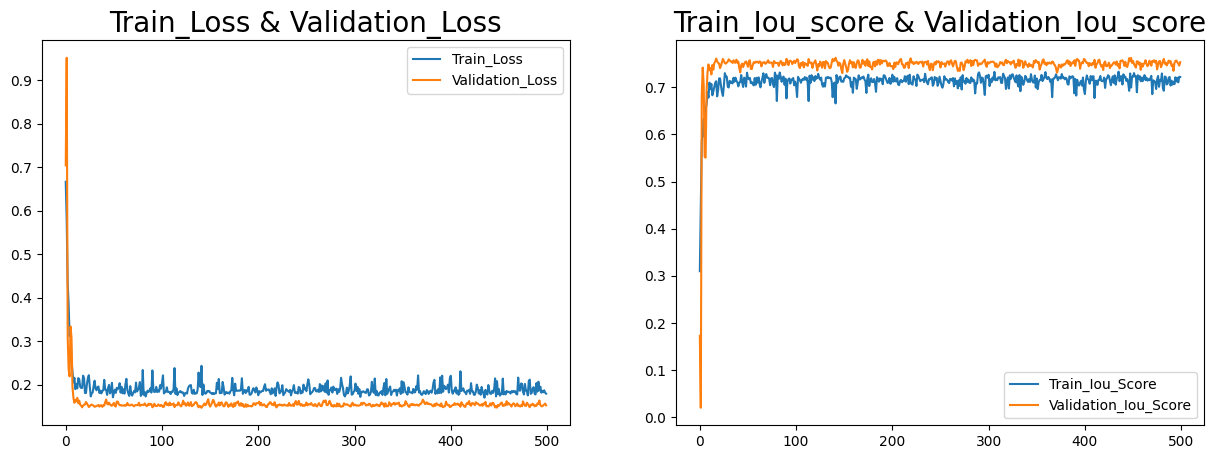

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
plt.legend()

In [24]:
test_transforms = A.Compose([
    A.Resize(512, 512),
    # ToTensorV2(),
])


In [25]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe,transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 2

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['images']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['masks'],cv2.IMREAD_GRAYSCALE)
        aug = self.transforms_(image=img, mask=mask)
        img, mask = aug['image'], aug['mask']
        img_view = np.copy(img)
        img = img/255
        # img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        mask_view = np.copy(mask)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target, 'img_view':img_view, 'mask_view':mask_view}
        return sample

test_dataset = TestDataset(test_df, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=4)


In [26]:
model.load_state_dict(torch.load('checkpoints/best1.pth'))
model.to(device)

def get_metrics(model, dataloader, threshold):
    IoU_score, precision, f1_score, recall, acc, dice_score = 0, 0, 0, 0, 0, 0
    batches = 0
    model.eval()
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch['x'].to(device), batch['y'].to(device)  # move data to GPU
            pred = model(x)
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()

            # Calculate stats
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=threshold)

            # Calculate various metrics
            batch_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            batch_acc = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
            batch_f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
            batch_recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro").item()
            batch_precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro").item()

            # Manually calculate Dice score
            dice = (2 * tp.sum()) / (2 * tp.sum() + fp.sum() + fn.sum())
            batch_dice_score = dice.item()

            # Aggregate the results
            IoU_score += batch_iou_score
            acc += batch_acc
            f1_score += batch_f1_score
            recall += batch_recall
            precision += batch_precision
            dice_score += batch_dice_score
            batches += 1

    # Compute average metrics over all batches
    IoU_score = round(IoU_score / batches, 3)
    precision = round(precision / batches, 3)
    f1_score = round(f1_score / batches, 3)
    recall = round(recall / batches, 3)
    acc = round(acc / batches, 3)
    dice_score = round(dice_score / batches, 3)

    sample = {
        'iou': IoU_score,
        'pre': precision,
        'fi': f1_score,
        're': recall,
        'acc': acc,
        'dice': dice_score
    }
    return sample

# Evaluate the model for different thresholds
threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in threshold_list:
    sample = get_metrics(model, test_loader, threshold)
    print(f"Threshold: {threshold:.2f} \
    IoU Score: {sample['iou']:.3f} \
    Precision: {sample['pre']:.3f} \
    F1 Score: {sample['fi']:.3f} \
    Recall: {sample['re']:.3f} \
    Accuracy: {sample['acc']:.3f} \
    Dice Score: {sample['dice']:.3f}")


<ipython-input-26-fb1de435b8dc>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/best1.pth'))


Threshold: 0.30     IoU Score: 0.712     Precision: 0.769     F1 Score: 0.832     Recall: 0.906     Accuracy: 0.941     Dice Score: 0.832
Threshold: 0.40     IoU Score: 0.715     Precision: 0.776     F1 Score: 0.834     Recall: 0.900     Accuracy: 0.942     Dice Score: 0.834
Threshold: 0.50     IoU Score: 0.716     Precision: 0.783     F1 Score: 0.835     Recall: 0.894     Accuracy: 0.943     Dice Score: 0.835
Threshold: 0.60     IoU Score: 0.717     Precision: 0.788     F1 Score: 0.835     Recall: 0.888     Accuracy: 0.943     Dice Score: 0.835
Threshold: 0.70     IoU Score: 0.718     Precision: 0.794     F1 Score: 0.836     Recall: 0.882     Accuracy: 0.944     Dice Score: 0.836
